In [1]:
# load the libraries required
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import os
from matplotlib import gridspec
from matplotlib.patches import Polygon ## for polygons
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from itertools import islice
import math
from itertools import product
from sklearn import preprocessing
from scipy.stats import gaussian_kde
import requests as rs
import re

from scipy import stats
from scipy.stats import gaussian_kde

%matplotlib inline

# image ploting
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# dictionary of epoc (key) and time range (value) in million years ago
geol_time_dict={'Holocene':(0,0.011700),
               'Pleistocene':(0.011700,2.58),
               'Pliocene':(2.58,5.333),
               'Miocene':(5.333,23.03),
               'Oligocene':(23.0,33.9),
               'Eocene':(33.9,56.0),
               'Paleocene':(56.0,66.0),
               'Late Cretaceous':(66.0,100.5),
               'Early Cretaceous':(100.5,145.0),
               'Jurassic':(145.0,201.3)}
# dictionary of epoc name (key) and list of colour and name abbreviation (value)
geol_col_dict={'Holocene':['#d6d6d6','Hol'], # dark grey
               'Pleistocene':['#ffffff','Ple'], # light grey
               'Pliocene':['#d6d6d6','Pli'],
               'Miocene':['#ffffff','Mio'],
               'Oligocene':['#d6d6d6','Oli'],
               'Eocene':['#ffffff','Eoc'],
               'Paleocene':['#d6d6d6','Pal'],
               'Late Cretaceous':['#ffffff','late Cret'],
              'Early Cretaceous':['#d6d6d6','early Cret'],
              'Jurassic':['#ffffff','Jur']}

# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

----

# 1. Fossil data 

----

## 1.1. Data and fossil age calculations

In [2]:
# def get_data():
#     return pd.read_csv('./pbdb_data_allcc.csv', skiprows=17, delimiter=',')
# try:
#     df = get_data()
# except:
# #     url = "https://paleobiodb.org/data1.2/occs/list.csv?datainfo&rowcount&cc=MG&show=full,genus"
#     url = "https://paleobiodb.org/data1.2/occs/list.csv?datainfo&rowcount&show=full,genus"
#     print("Downloading from the Paleobiology database...")
#     res = rs.get(url=url)
# #     with open('./pbdb_data_MG.csv', 'wb') as fp:
#     with open('./pbdb_data_allcc.csv', 'wb') as fp:
#         fp.write(res.content)
#     df = get_data()

# reads the fossil data downloaded by Daniel Edler using the code above
df = pd.read_csv('./Fossils-Madagascar/Genera_records_world.csv', sep=',')
df.columns
# replace no data with zero
df[['early_age', 'late_age']] = df[['early_age', 'late_age']].replace(np.nan,0)
# selects the fossil records from 160 Mya inclusive
df = df[df['early_age'] <= 160].reset_index()
# early age: towards past; late age: towards present
df[['early_age', 'late_age']].describe()

,early_age,late_age
count,13126.000000,13126.000000
mean,41.446046,35.972068
std,45.011763,40.978979
min,0.011700,0.000000
25%,0.781000,0.011700
50%,15.970000,13.600000
75%,83.500000,70.600000
max,145.000000,140.200000


In [3]:
# fossils are dated with a range rather than a single year to accomodate uncertainty on time estimates
# plotting the fossil data either using the early or late ages means that most points will have the same age and visualizing the data as that is uninformative
# to plot fossil data so it is informative, we took the mean age of the fossil and added it to the late_age if the difference between early and late ages is >=1
# if the difference between early and late ages is <1 we simply assigned a random age between the early and late age estimates
# that is to add a sort of "jitter" to the age estimates that is closer to the mean age than to a random number (in case the age range is wide)
def enhance_ma(df):
    df['delta_ma'] = df['early_age'] - df['late_age']
    df['mean_ma'] = df['late_age'] + 0.5*df['delta_ma']
    df['rand_ma'] = df.apply(lambda row: row['mean_ma'] if row['delta_ma'] < 1 else np.random.randint(row['late_age'], row['early_age']), axis=1)

enhance_ma(df)
df[['early_age', 'late_age', 'delta_ma', 'mean_ma', 'rand_ma']]

,early_age,late_age,delta_ma,mean_ma,rand_ma
0,113.0000,100.500,12.5000,106.75000,108.00000
1,132.9000,129.400,3.5000,131.15000,131.00000
2,139.8000,132.900,6.9000,136.35000,135.00000
3,113.0000,100.500,12.5000,106.75000,103.00000
4,59.2000,56.000,3.2000,57.60000,57.00000
...,...,...,...,...,...
13121,0.0117,0.000,0.0117,0.00585,0.00585
13122,15.9700,13.600,2.3700,14.78500,14.00000
13123,13.0000,125.450,-112.4500,69.22500,69.22500
13124,0.7810,0.126,0.6550,0.45350,0.45350


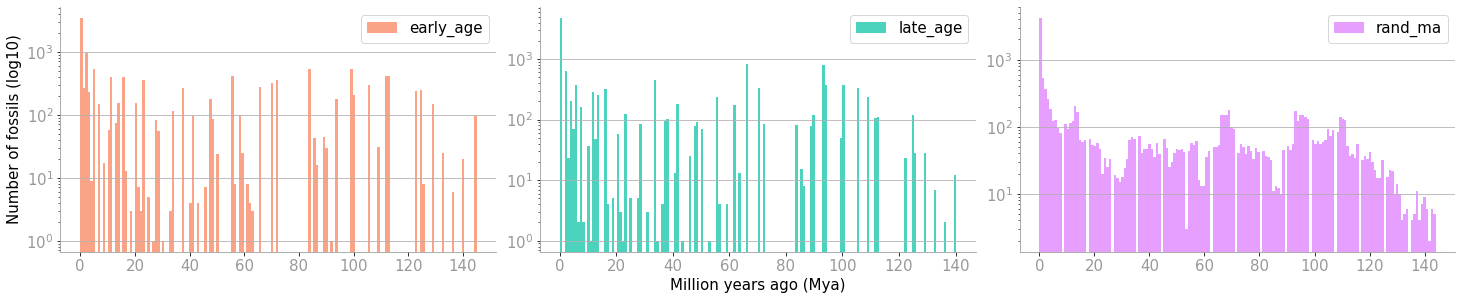

In [4]:
# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,1.5*3),facecolor='w')
G = gridspec.GridSpec(1,3,hspace=0.0,wspace=0.1)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'
for index,data in enumerate(ages):
    ax=plt.subplot(G[0,index])
    ax.hist(df[ages[index]],bins=160,lw=3,color=colours[index],alpha=0.7,label=ages[index], # 160 bins, 160 Mya
       histtype='stepfilled')
    [ax.spines[loc].set_visible(False) for loc in ['right','top']]
    for spine in ax.spines.values():
        spine.set_edgecolor(spinescol)
    if index == 0:
        plt.ylabel('Number of fossils (log10)',fontsize=15)
    if index == 1:
        plt.xlabel('Million years ago (Mya)',fontsize=15)
    plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
    plt.grid(axis='y')
    plt.yscale('log') # to see the data better
    plt.legend(fontsize=15)
plt.show()

## 1.2. Standardising fossil taxa

In [5]:

print('Example of the information in columns taxon_name, phylum, class, family\n',df[['taxon_name','phylum','class','family']])
print('\n','-'*100,'\n')
print('Unique values in the class column:\n',df['class'].unique())

# adding missing data in the common_name column depending on the value of the phylum column and in whether the class column is empty
for row in df[df['class'].isna()].itertuples():
    if row.phylum == 'Angiospermae':
        df.loc[row.Index,'common_name'] = 'Magnoliopsida'
    if row.phylum == 'Coniferophyta':
        df.loc[row.Index,'common_name'] = 'Other plants'
        
# creates dictionary with the names we need to correct
# we chose these names because they make more sense for a broader public
common_name_dict = {'Mammalia':'Mammals',
                    'Aves':'Birds',
                    'Magnoliopsida':'Flowering plants',
                    'Reptilia':'Reptiles',
                    'Ginkgoopsida':'Other plants',
                    'Saurischia':'Dinosaurs',
                    'Osteichthyes':'Bony fishes'}
# creates new column of common names and maps the chages using the dictionary
df['common_name'] = df['class'].map(common_name_dict)

print('\n','-'*100,'\n')
print('Unique values in the common name column:\n',df['common_name'].unique())

Example of the information in columns taxon_name, phylum, class, family
                     taxon_name    phylum           class             family
0        Otodus appendiculatus  Chordata  Chondrichthyes        Otodontidae
1           Odontaspis studeri  Chordata  Chondrichthyes     Odontaspididae
2           Odontaspis studeri  Chordata  Chondrichthyes     Odontaspididae
3               Corax falcatus  Chordata  Chondrichthyes       Anacoracidae
4            Isurus acuminatus  Chordata  Chondrichthyes           Lamnidae
...                        ...       ...             ...                ...
13121  Coturnix novaezelandiae  Chordata            Aves        Phasianidae
13122    Phalacrocorax auritus  Chordata            Aves  Phalacrocoracidae
13123        Lepidotus cf. sp.  Chordata     Actinopteri                NaN
13124           Ardea herodias  Chordata            Aves           Ardeidae
13125        Casmerodius albus  Chordata            Aves           Ardeidae

[13126 rows x 

In [6]:
# standardizing taxonomic names when possible
# we did not merge e.g. 'genus cf species' and 'genus species' because we dont have evidence supporting that
tax_dict={'Adinophis n. gen. fisaka n. sp.':'Adinophis fisaka',
          'Beelzebufo n. gen. ampinga n. sp.':'Beelzebufo ampinga',
          'Centrornis n. gen. majori n. sp.':'Centrornis majori',
          'Coua berthae n. sp.':'Coua berthae',
          'Crocodilus robustus':'Crocodylus robustus',
          'Crocodylus robustus n. sp.':'Crocodylus robustus',
          'Hadropithecus n. gen. stenognathus n. sp.':'Hadropithecus stenognathus',
          'Hippopotamus lemerlei n. sp.':'Hippopotamus lemerlei',
          'Kelyophis n. gen. hechti n. sp.':'Kelyophis hechti',
          'Kinkonychelys n. gen. rogersi n. sp.':'Kinkonychelys rogersi',
          'Lavanify n. gen. miolaka n. sp.':'Lavanify miolaka',
          'Madtsoia madagascariensis n. sp.':'Madtsoia madagascariensis',
          'Mahajangasuchus n. gen. insignis n. sp.':'Mahajangasuchus insignis',
          'Majungasaurus n. gen. crenatissimus':'Majungasaurus crenatissimus',
          'Margaroperdix madagascarensis':'Margaroperdix madagascariensis',
          'Masiakasaurus n. gen. knopfleri n. sp.':'Masiakasaurus knopfleri',
          'Megalosaurus crenatissimus n. sp.':'Megalosaurus crenatissimus',
          'Menarana n. gen. nosymena n. sp.':'Menarana nosymena',
          'Rapetosaurus n. gen. krausei n. sp.':'Rapetosaurus krausei',
          'Simosuchus n. gen. clarki n. sp.':'Simosuchus clarki',
          'Sokatra n. gen. antitra n. sp.':'Sokatra antitra',
          'Stephanoaetus mahery n. sp.':'Stephanoaetus mahery',
          'Titanosaurus madagascariensis n. sp.':'Titanosaurus madagascariensis',
          'Vahiny n. gen. depereti n. sp.':'Vahiny depereti',
          'Vorona n. gen. berivotrensis n. sp.':'Vorona berivotrensis'}

In [7]:
df['taxon_name_original']=''
df.loc[df.index,'taxon_name_original']=df['taxon_name']

for i, row in enumerate(df.itertuples()):
    if str(row.taxon_name_original) in tax_dict.keys():
        df.loc[i,'taxon_name']=tax_dict[row.taxon_name_original]
#     print(i, row.taxon_name_original)
# df.loc[df.index,'taxon_name']=df['taxon_name_original'].map(tax_dict)
df[df['taxon_name']=='Vahiny depereti'][['taxon_name','taxon_name_original']]

,taxon_name,taxon_name_original
8091,Vahiny depereti,Vahiny depereti
8092,Vahiny depereti,Vahiny n. gen. depereti n. sp.


In [8]:
df['taxon_name'] # spp not in dict should not have changed.

0          Otodus appendiculatus
1             Odontaspis studeri
2             Odontaspis studeri
3                 Corax falcatus
4              Isurus acuminatus
                  ...           
13121    Coturnix novaezelandiae
13122      Phalacrocorax auritus
13123          Lepidotus cf. sp.
13124             Ardea herodias
13125          Casmerodius albus
Name: taxon_name, Length: 13126, dtype: object

### Now, let's see how the plots look like if we only include species found and endemic to Madagascar

## 1.3. Colour dictionaries for common names

In [9]:
# costum
orcoldict = {'Flatworms': '#DDDDDD',
    'Molluscs': '#A3A3A3',
    'Bony fishes': '#2F4858',
    'Arthropods': '#287990',
    'Amphibians': '#26A390',
    'Reptiles': '#BBCC76',
    'Birds': '#ffc4a8',
    'Mammals': '#f58a6f',
    'Flowering plants': '#bd5943',
    'Ferns': '#980f06',
    'Other plants': '#980f06',
    'Dinosaurs': '#620a04'}

In [10]:
# species found in Madagascar (including endemics and species found somewhere else but these are only fossils FROM MG)
df[(df['cc'] == 'MG')]

,index,occurrence_no,record_type,collection_no,taxon_name,taxon_rank,taxon_no,matched_name,matched_rank,matched_no,...,regionalsection,regionalbed,regionalorder,subgenus_name,subgenus_reso,delta_ma,mean_ma,rand_ma,common_name,taxon_name_original
1199,1199,259315,occurrence,25074,Vorona berivotrensis,species,64129,Vorona berivotrensis,species,64129,...,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,70.00000,Birds,Vorona n. gen. berivotrensis n. sp.
1410,1410,343957,occurrence,32366,Majungasaurus crenatissimus,species,53957,Majungasaurus crenatissimus,species,53957,...,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,67.00000,Dinosaurs,Majungasaurus crenatissimus
1936,1936,405967,occurrence,39074,Rapetosaurus krausei,species,57533,Rapetosaurus krausei,species,57533,...,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,70.00000,Dinosaurs,Rapetosaurus n. gen. krausei n. sp.
1937,1937,405968,occurrence,25074,Rapetosaurus krausei,species,57533,Rapetosaurus krausei,species,57533,...,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,67.00000,Dinosaurs,Rapetosaurus krausei
1955,1955,408132,occurrence,32366,Araripesuchus tsangatsangana n. sp.,species,157803,Araripesuchus tsangatsangana,species,157803,...,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,69.00000,Reptiles,Araripesuchus tsangatsangana n. sp.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12026,12026,1468983,occurrence,205193,Geckolepis sp.,genus,37904,Geckolepis,genus,37904,...,NaN,NaN,NaN,NaN,NaN,0.0117,0.00585,0.00585,Reptiles,Geckolepis sp.
12311,12311,1506143,occurrence,208970,Adalatherium n. gen. hui n. sp.,species,419515,Adalatherium hui,species,419515,...,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,68.00000,Mammals,Adalatherium n. gen. hui n. sp.
12773,12773,1527464,occurrence,214154,Akoranemys n. gen. madagasika n. sp.,species,426666,Akoranemys madagasika,species,426666,...,NaN,NaN,NaN,NaN,NaN,6.6000,97.20000,96.00000,Reptiles,Akoranemys n. gen. madagasika n. sp.
12882,12882,1534912,occurrence,215531,Dromas ardeola,species,402081,Dromas ardeola,species,402081,...,NaN,NaN,NaN,NaN,NaN,0.0117,0.00585,0.00585,Birds,Dromas ardeola


### All fossils found in MG

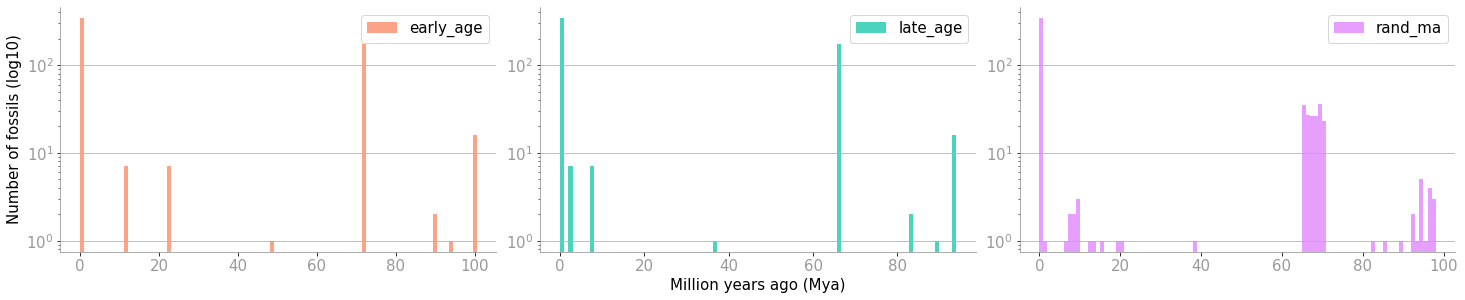

In [11]:
# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,1.5*3),facecolor='w')
G = gridspec.GridSpec(1,3,hspace=0.0,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for index,data in enumerate(ages):
    ax=plt.subplot(G[0,index])
    
    # set the bins
    bins=int(dfMG[ages[index]].max())
    
    # number of bins has to be the max age number in integer to create a bin per 1mya
    ax.hist(dfMG[ages[index]],bins=bins,lw=3,color=colours[index],alpha=0.7,label=ages[index], # 160 bins, 160 Mya
       histtype='stepfilled')
    
    [ax.spines[loc].set_visible(False) for loc in ['right','top']]
    for spine in ax.spines.values():
        spine.set_edgecolor(spinescol)
    if index == 0:
        plt.ylabel('Number of fossils (log10)',fontsize=15)
    if index == 1:
        plt.xlabel('Million years ago (Mya)',fontsize=15)
        
    plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
    plt.grid(axis='y')
    plt.yscale('log') # to see the data better
    plt.legend(fontsize=15)
plt.show()

## 1.4. Pre-visualise the fossil data by common name

### All fossils found in MG by group

In [12]:
dfMG['common_name'].unique()

array(['Birds', 'Dinosaurs', 'Reptiles', 'Mammals', nan, 'Bony fishes',
       'Other plants', 'Flowering plants'], dtype=object)

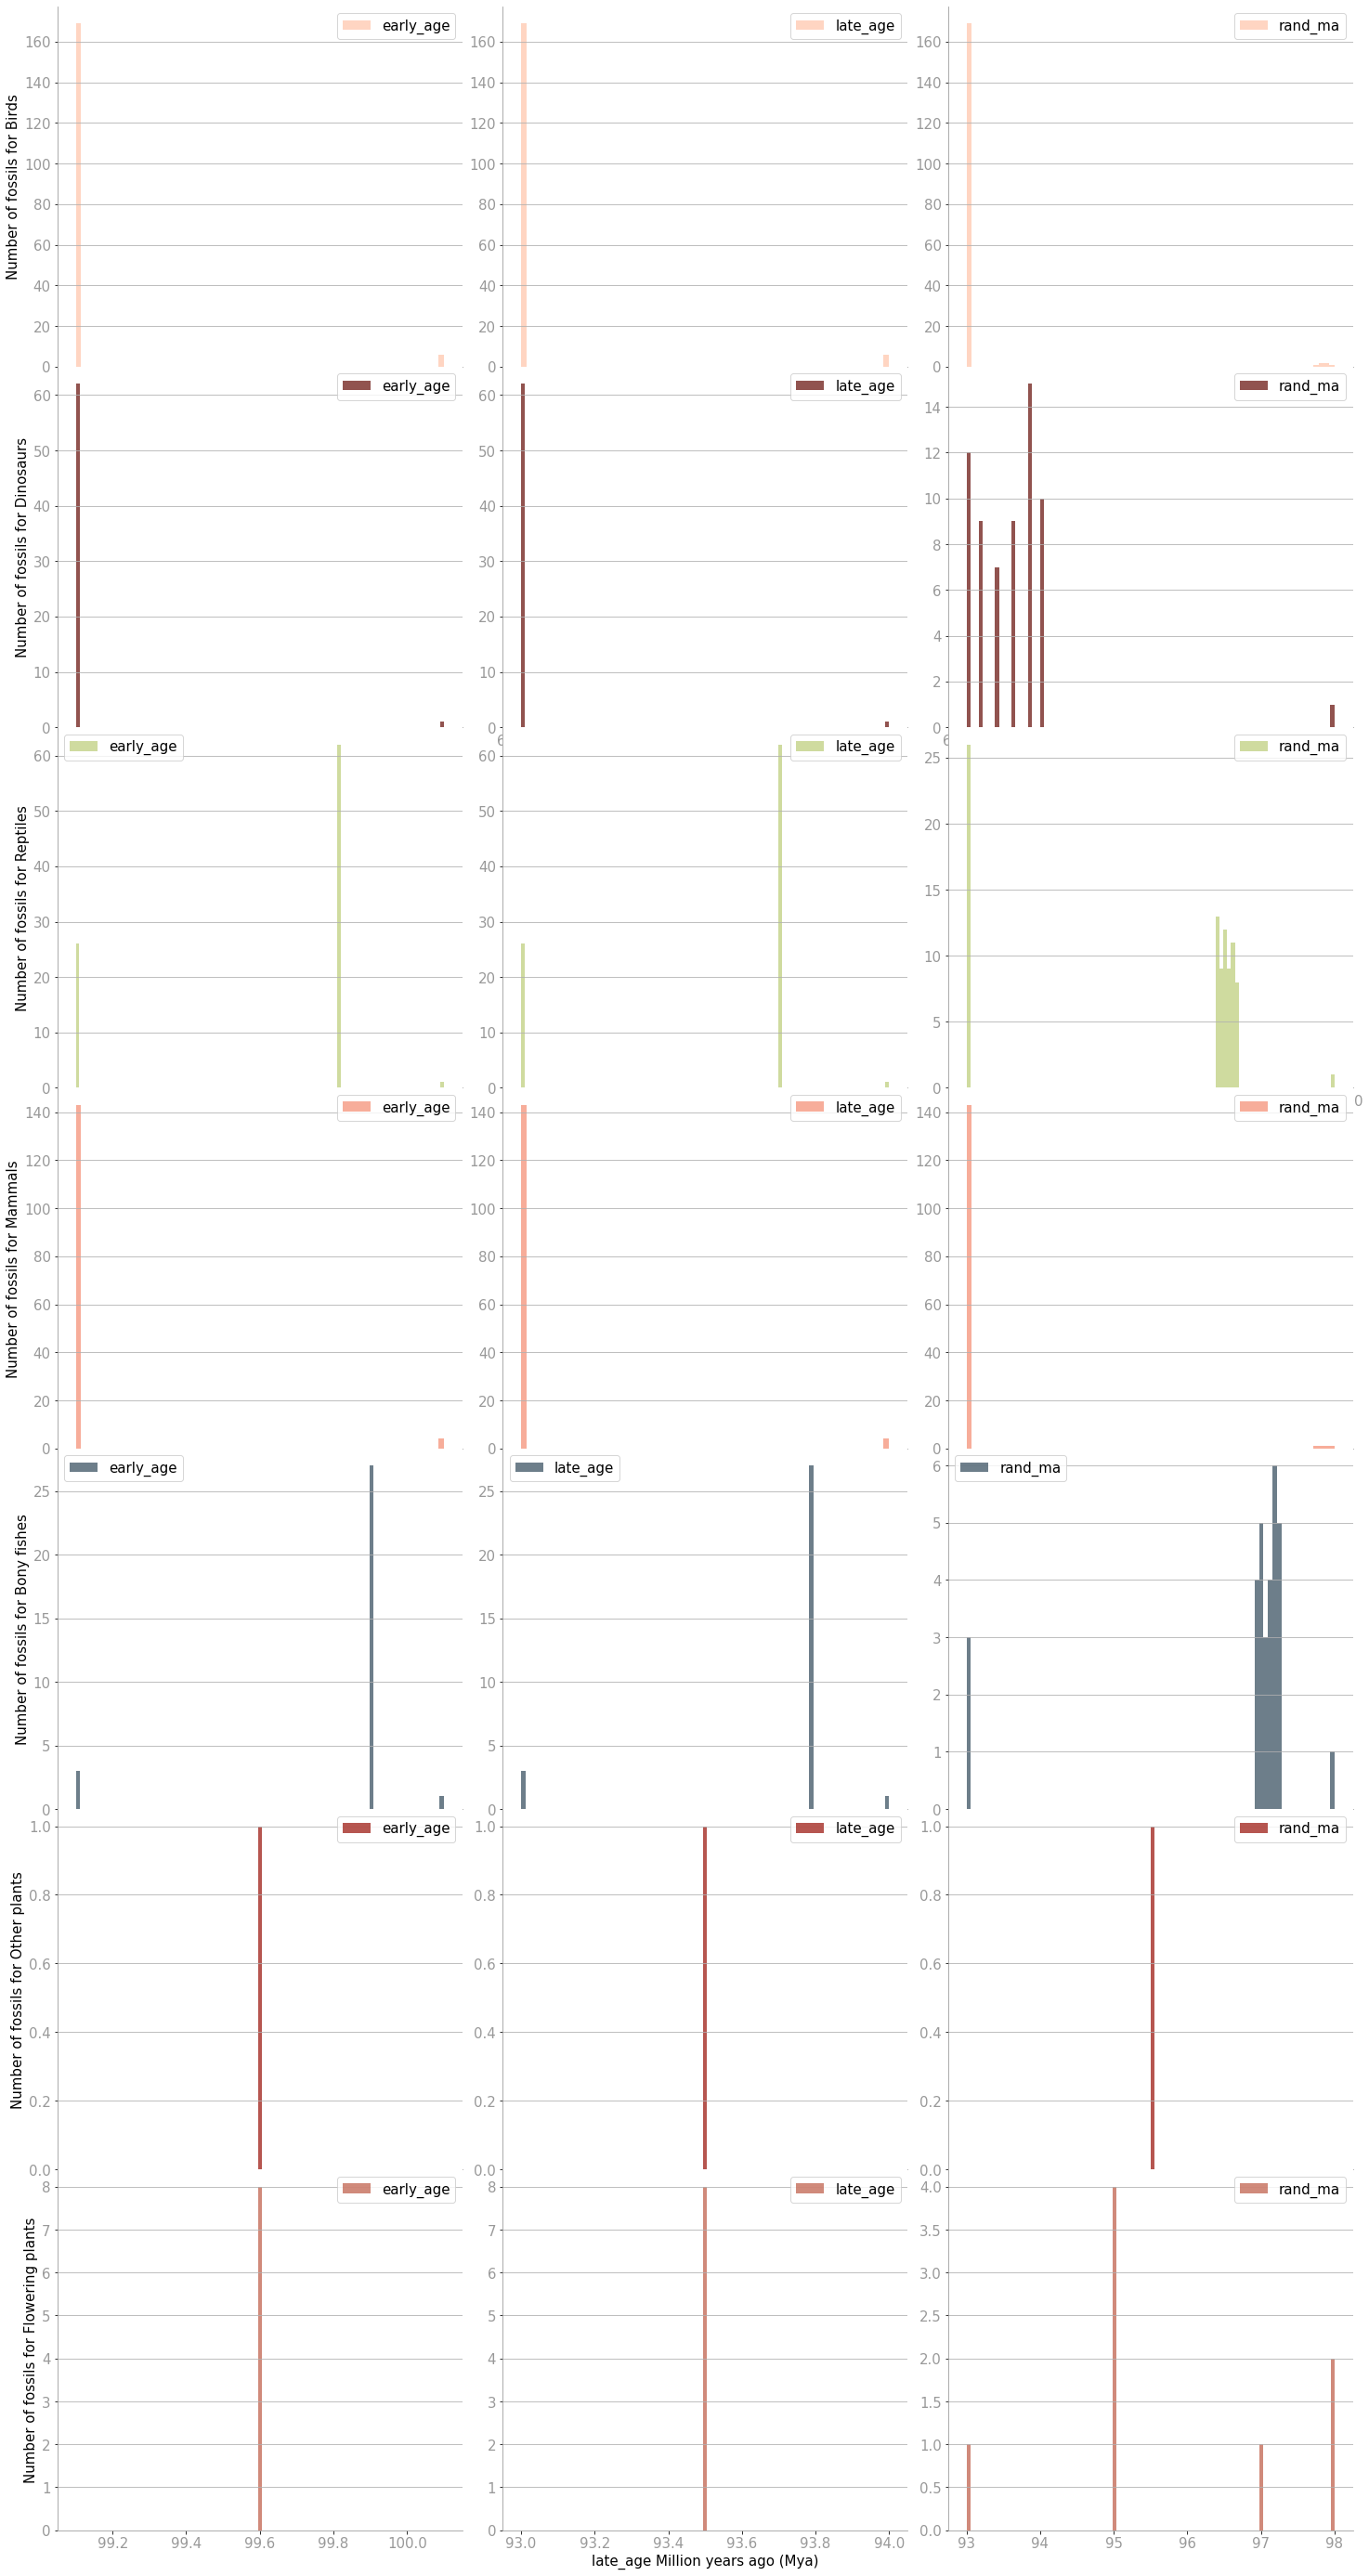

In [13]:
names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,50),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.0,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)
    
    for index,data in enumerate(ages):
        ax=plt.subplot(G[ind,index])
#         try:
            # set the bins
#             print(dfMGtemp[ages[index]].max())
        bins=int(dfMGtemp[ages[index]].astype('float').max())

        # number of bins has to be the max age number in integer to create a bin per 1mya
        ax.hist(dfMGtemp[ages[index]],bins=bins,lw=3,color=orcoldict[name],alpha=0.7,label=ages[index]), # 160 bins, 160 Mya
#                histtype='stepfilled')

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of fossils for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### Unique species of fossils found in MG

In [14]:
dfMG['taxon_name']

1199                     Vorona berivotrensis
1410              Majungasaurus crenatissimus
1936                     Rapetosaurus krausei
1937                     Rapetosaurus krausei
1955      Araripesuchus tsangatsangana n. sp.
                         ...                 
12026                          Geckolepis sp.
12311         Adalatherium n. gen. hui n. sp.
12773    Akoranemys n. gen. madagasika n. sp.
12882                          Dromas ardeola
13075    Falcatakely n. gen. forsterae n. sp.
Name: taxon_name, Length: 548, dtype: object

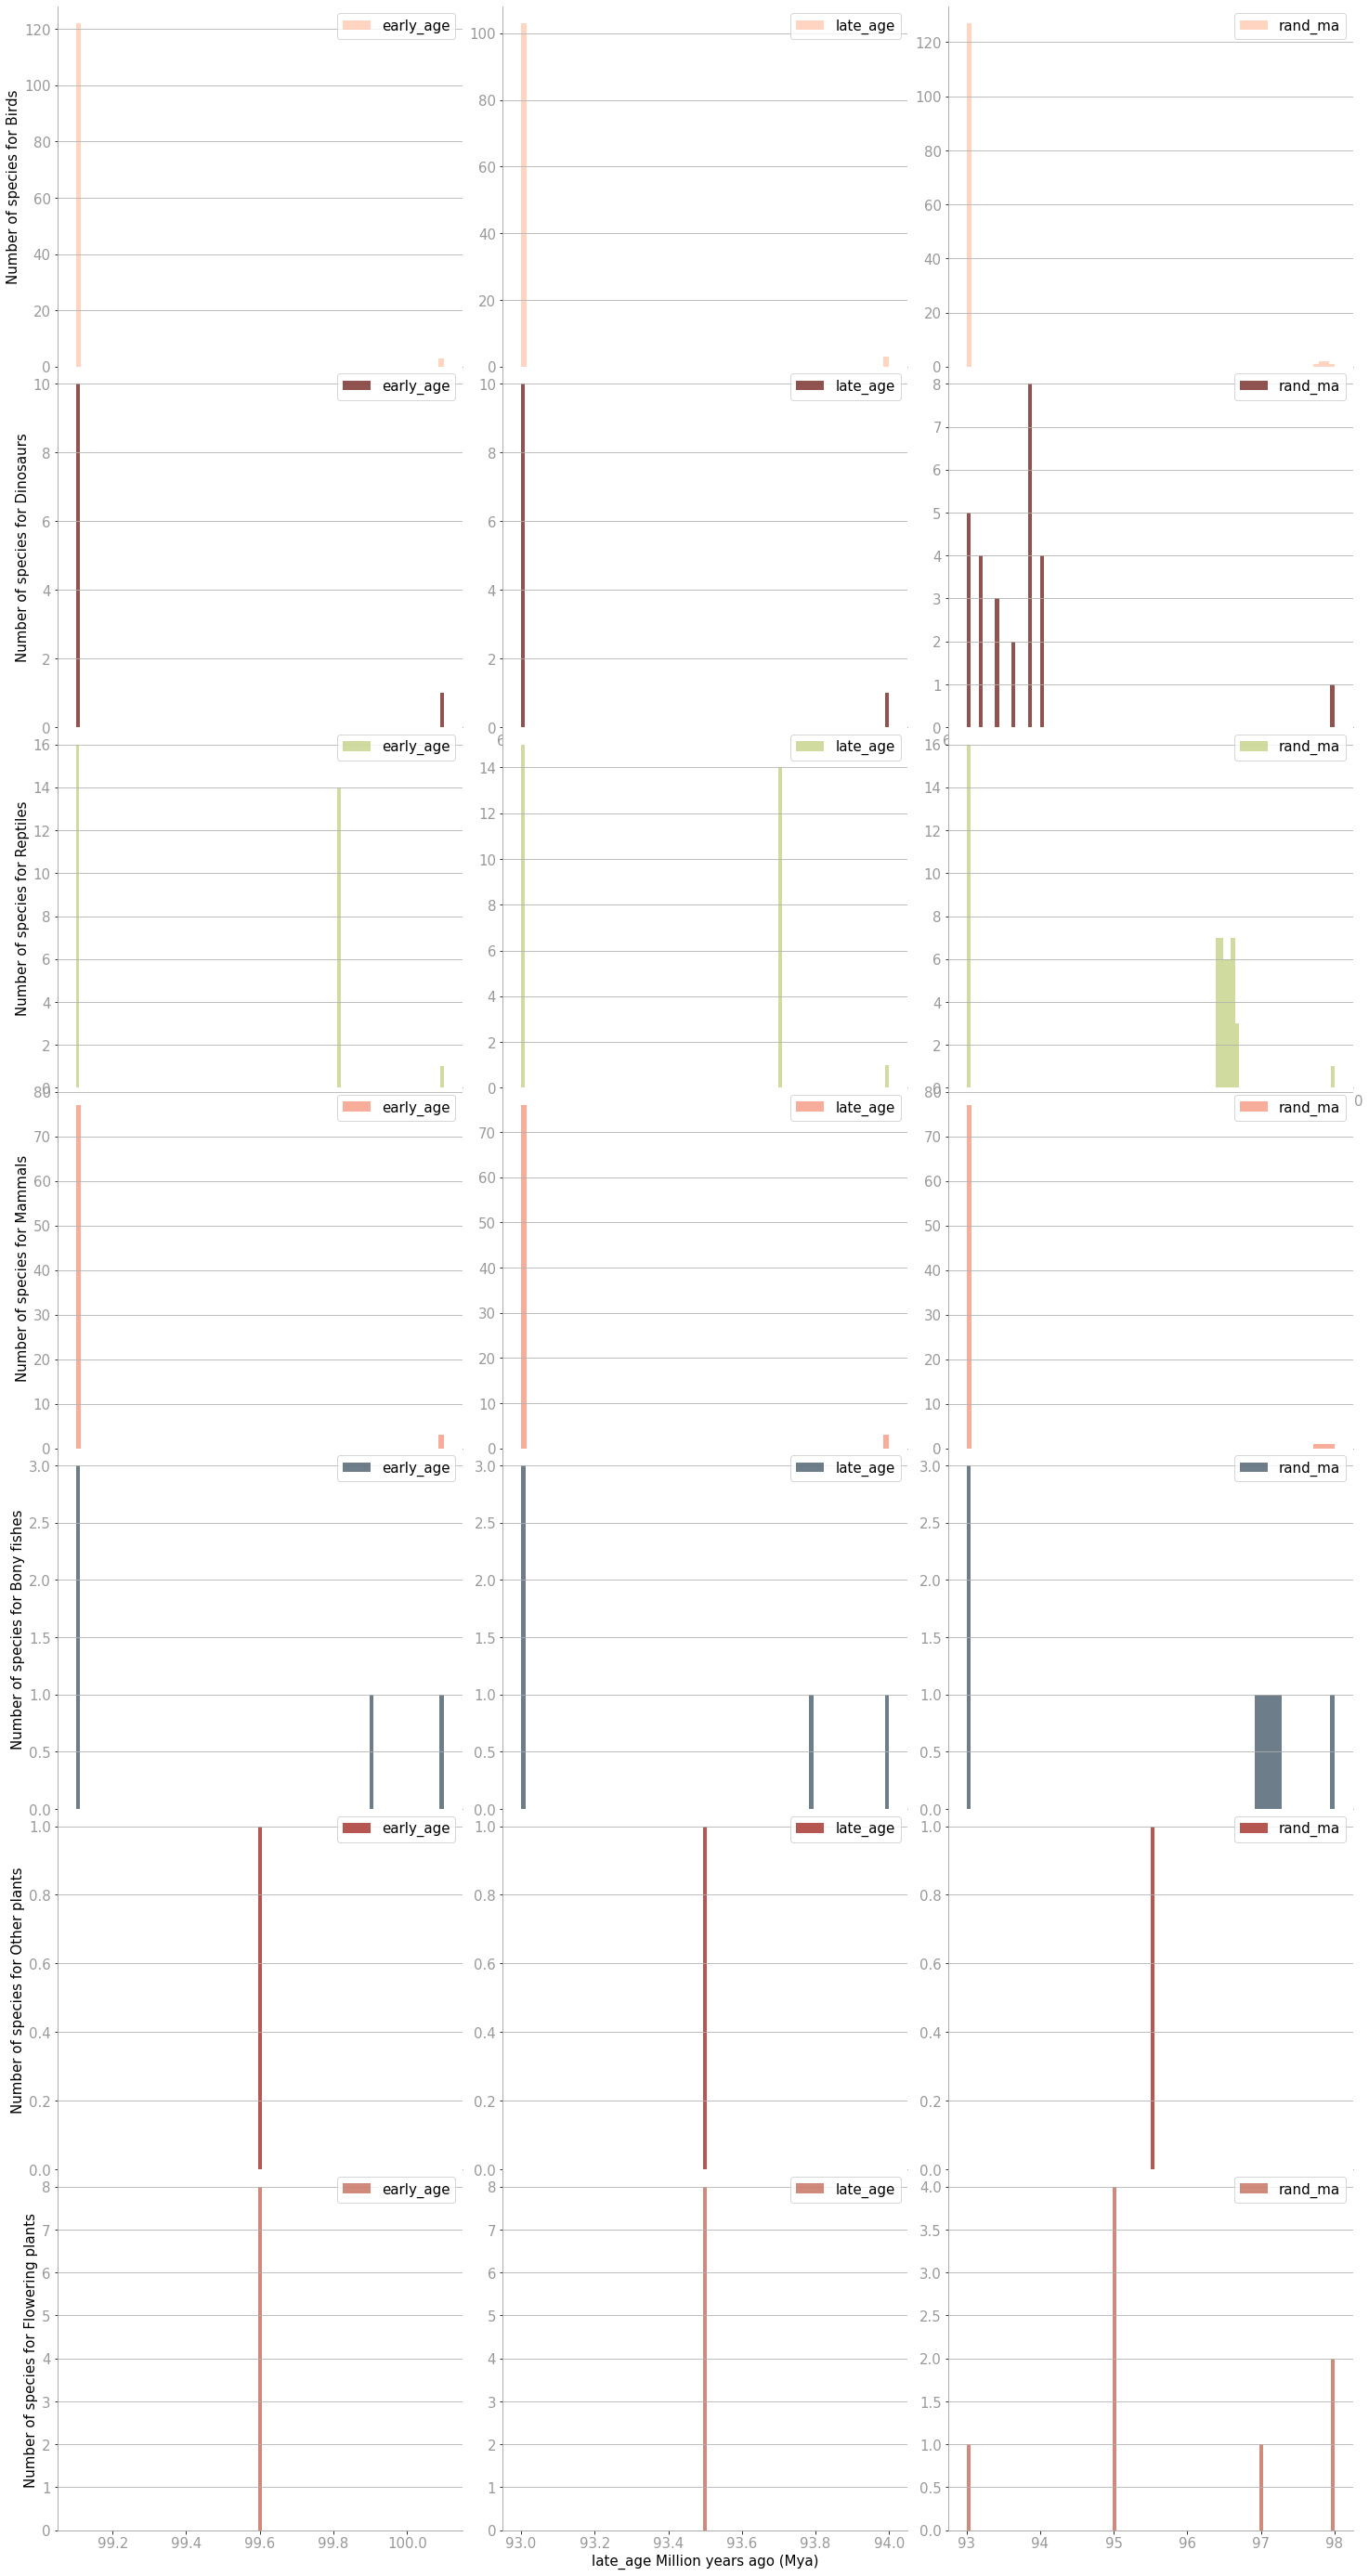

In [15]:
names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,50),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.0,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)

    for index,data in enumerate(ages):
        # group by unique species and time
        byspp=dfMGtemp.groupby(['taxon_name']+[data]).count().reset_index()
        
        ax=plt.subplot(G[ind,index])
        bins=int(byspp[ages[index]].astype('float').max())

        # number of bins has to be the max age number in integer to create a bin per 1mya
        ax.hist(byspp[ages[index]],bins=bins,lw=3,color=orcoldict[name],alpha=0.7,label=ages[index]), # 160 bins, 160 Mya
#                histtype='stepfilled')

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### Unique fossil species from MG through time, size of dots represents number of individual fossils

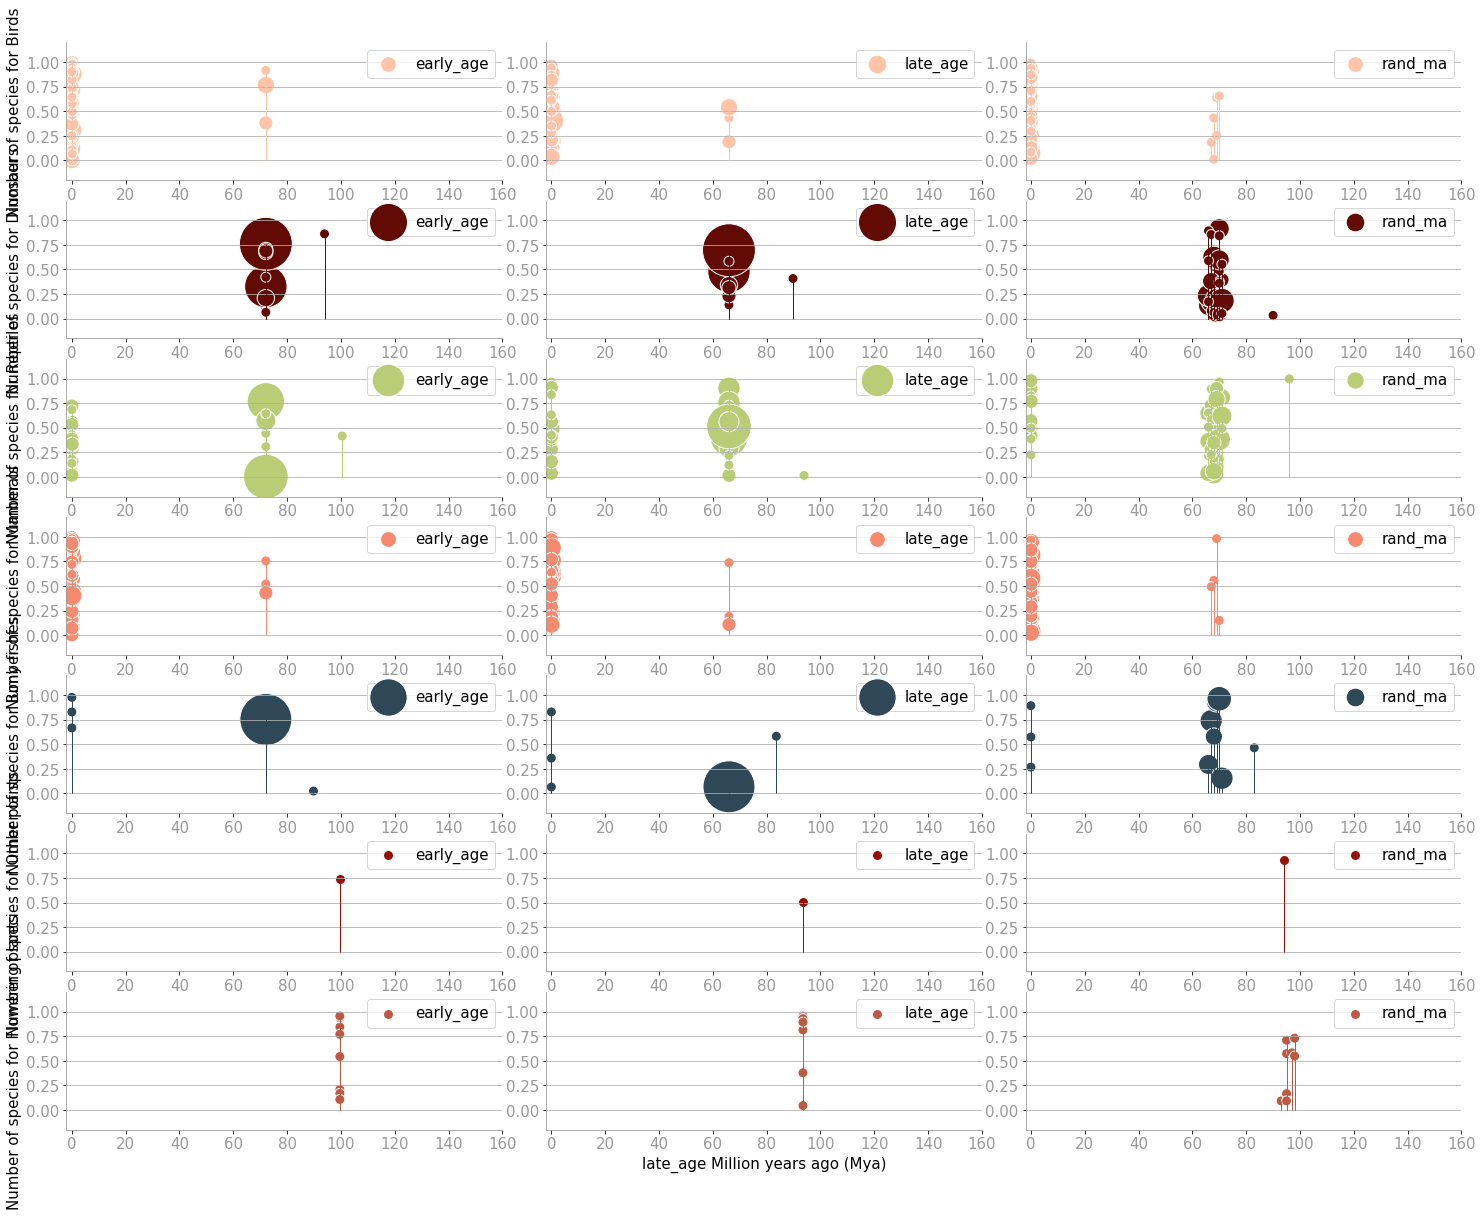

In [16]:
import random

names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,20),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.15,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)

    for index,data in enumerate(ages):
        # group by unique species and time
        byspp=dfMGtemp.groupby(['taxon_name']+[data]).count().reset_index()
#         print(byspp[['taxon_name','early_age','late_age','rand_ma','occurrence_no']].isna().describe())
        
        ax=plt.subplot(G[ind,index])
        ax.set_xlim(-2,160); ax.set_ylim(-0.2,1.2)
        
        yrandomlist=[]
        for line in byspp[data].values:
            yrandom=random.uniform(0, 1)
            yrandomlist.append(yrandom)
            ax.vlines(x=line, ymin=0, ymax=yrandom,color=orcoldict[name], lw=1)
            
        ax.scatter(x=byspp[data], y=yrandomlist, facecolor=orcoldict[name], edgecolor='w',
                   marker='o', s=byspp['occurrence_no']*100, alpha=1, label=data)

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### Unique fossil species from MG through time, size of dots represents number of unique species

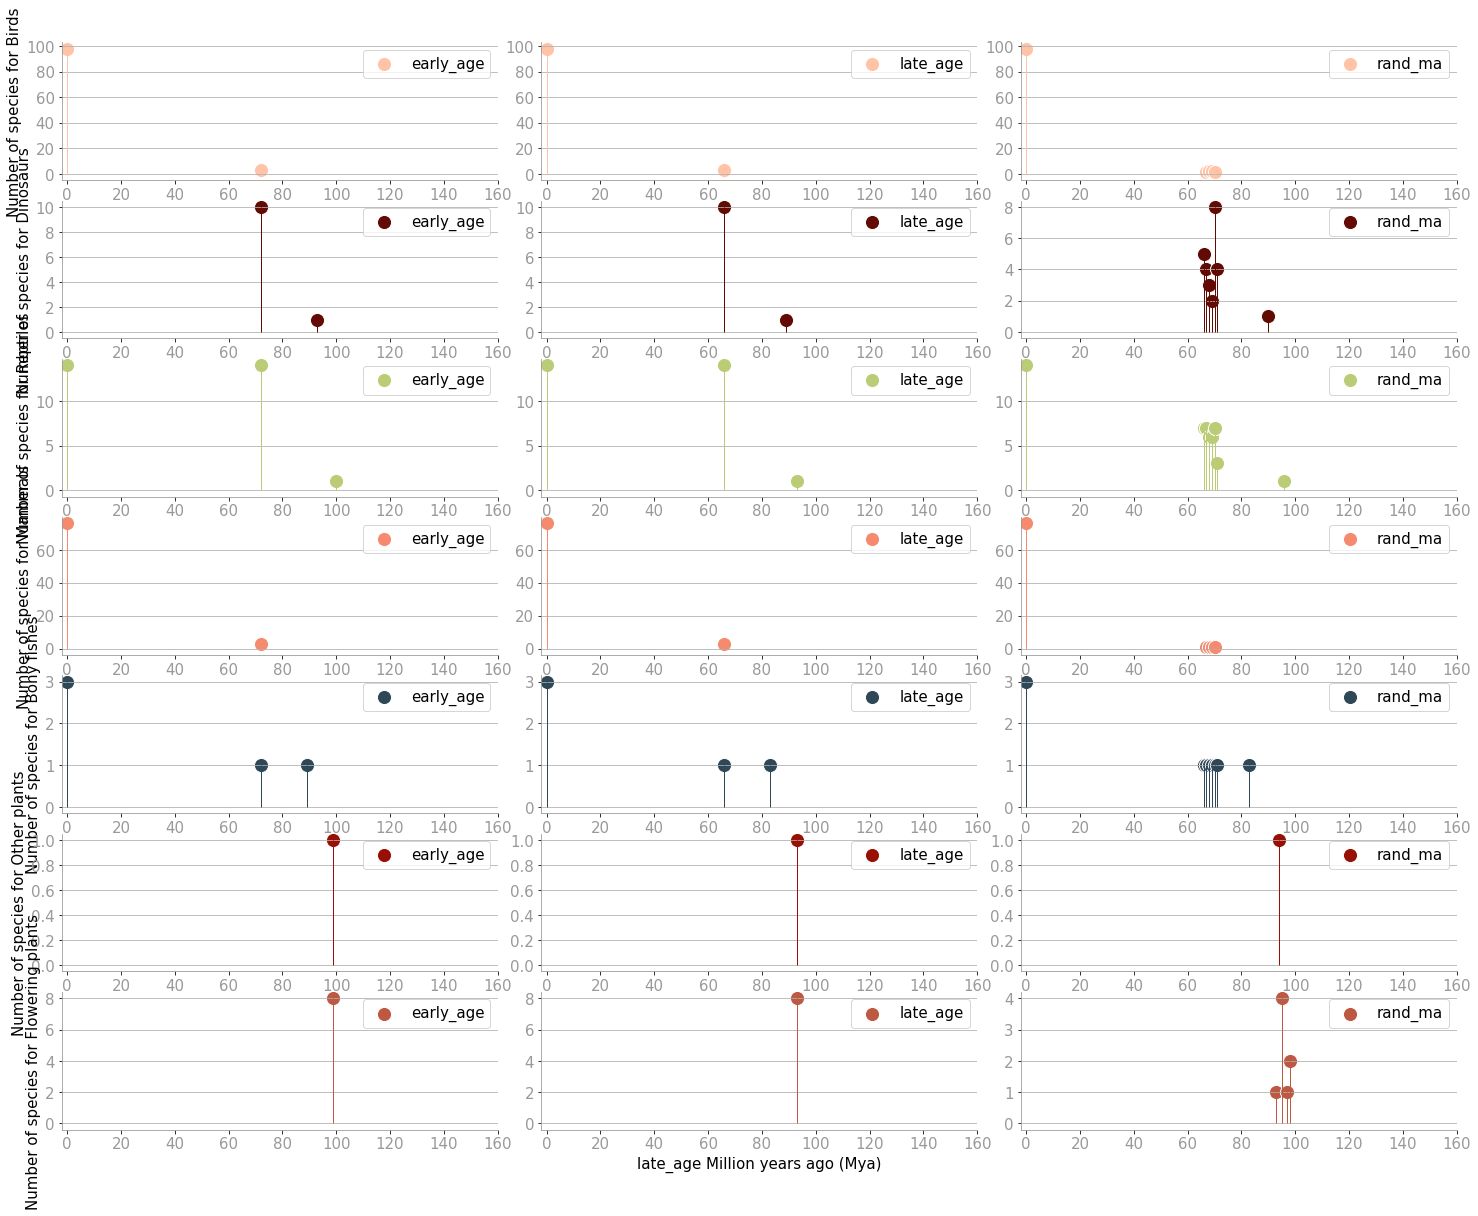

In [17]:
import random

names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,20),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.15,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)
    
    for index,data in enumerate(ages):
        # make time integer so that I can group by year and count the number of unique species
        dfMGtemp.loc[dfMGtemp.index,data]=dfMGtemp.loc[dfMGtemp.index,data].astype('int')
    
        # group by unique species and time
        byspp=dfMGtemp.groupby(data).nunique()['taxon_name'].reset_index()
#         print(byspp.head())
        
        ax=plt.subplot(G[ind,index])
        ax.set_xlim(-2,160); #ax.set_ylim(0,1.2)
            
        ax.scatter(x=byspp[data], y=byspp['taxon_name'], facecolor=orcoldict[name], edgecolor='w',
                   marker='o', s=200, alpha=1, label=data)
        ax.vlines(x=byspp[data], ymin=0, ymax=byspp['taxon_name'],color=orcoldict[name], lw=1)

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### with endemics highlighted

In [18]:
# list of fossils found only in one country
taxon_countries = df.groupby('taxon_name').nunique()['cc'].reset_index()
    # make a list of the taxons found only in one country
singlecountry = list(taxon_countries[taxon_countries['cc'] == 1]['taxon_name'])

# filter the data so that only taxon found in a single country and in Madagascar are left
endemic = df[ (df['taxon_name'].isin(singlecountry)) & (df['cc'] =='MG') ]
endemic[['taxon_name','cc']]

,taxon_name,cc
1199,Vorona berivotrensis,MG
1410,Majungasaurus crenatissimus,MG
1936,Rapetosaurus krausei,MG
1937,Rapetosaurus krausei,MG
1955,Araripesuchus tsangatsangana n. sp.,MG
...,...,...
12026,Geckolepis sp.,MG
12311,Adalatherium n. gen. hui n. sp.,MG
12773,Akoranemys n. gen. madagasika n. sp.,MG
12882,Dromas ardeola,MG


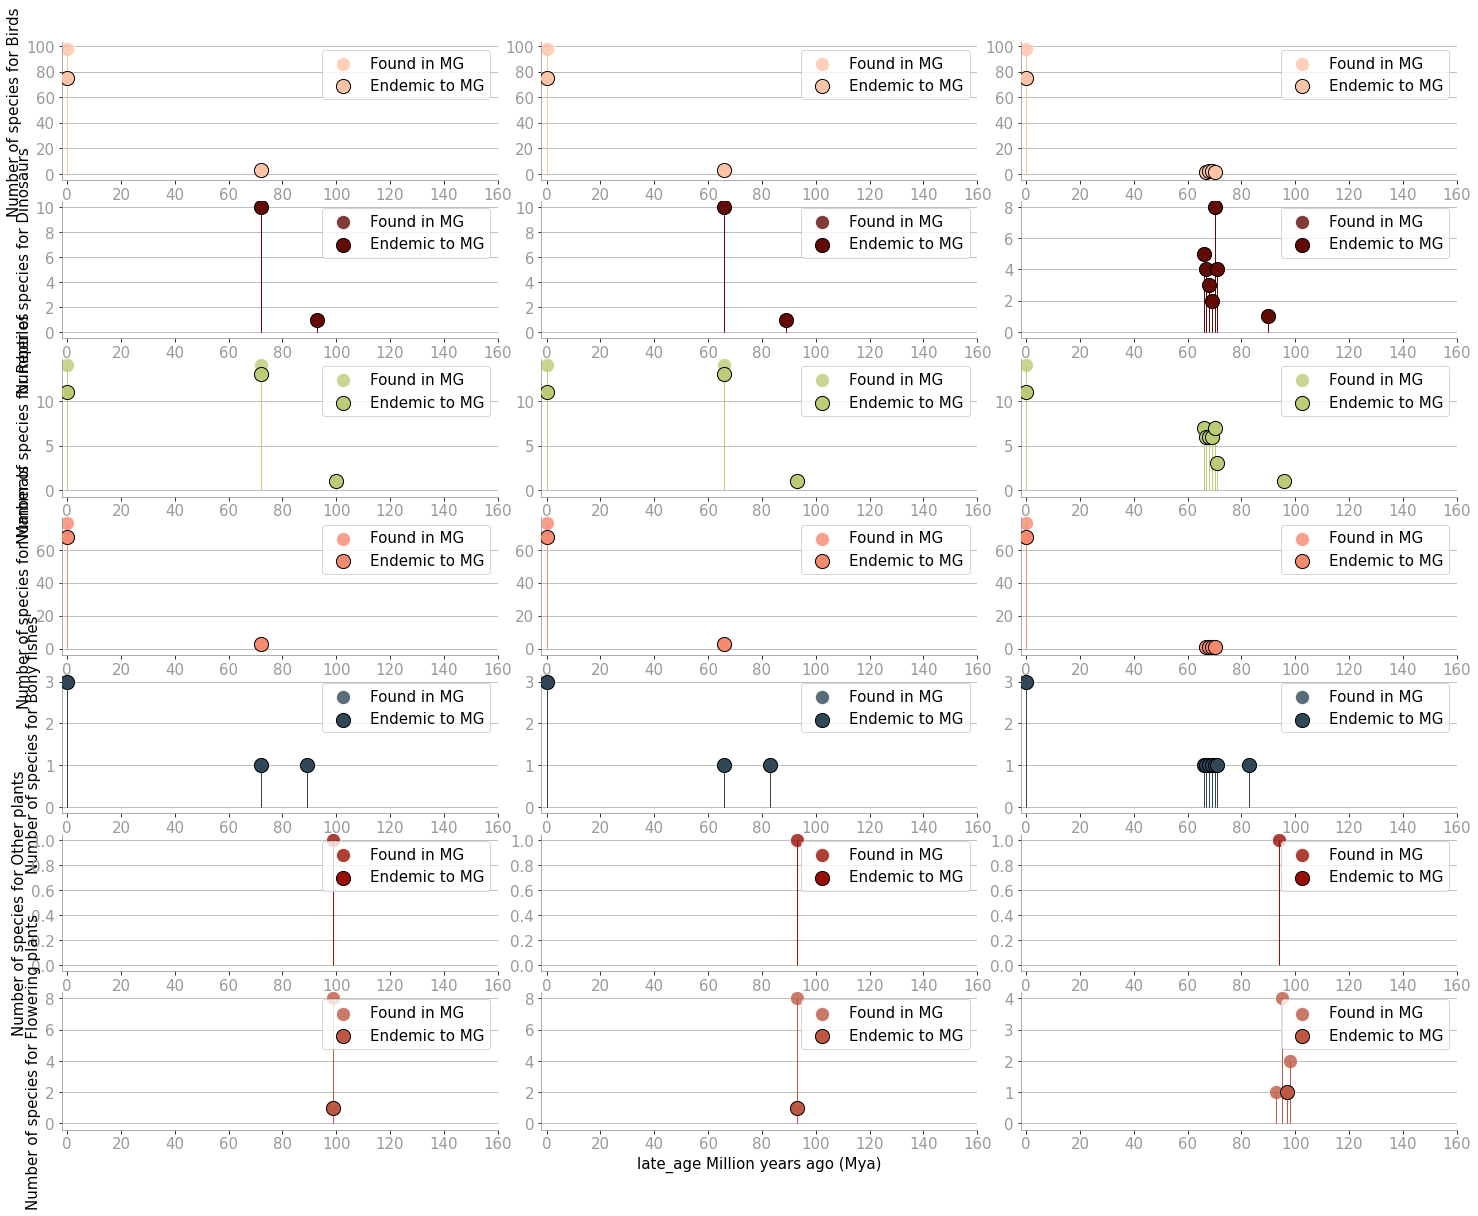

In [19]:
names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,20),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.15,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)
    endemictemp=endemic[endemic['common_name']==name].copy(deep=True)
    
    for index,data in enumerate(ages):
        # make time integer so that I can group by year and count the number of unique species
        dfMGtemp.loc[dfMGtemp.index,data]=dfMGtemp.loc[dfMGtemp.index,data].astype('int')
        endemictemp.loc[endemictemp.index,data]=dfMGtemp.loc[endemictemp.index,data].astype('int')
        
        # group by unique species and time
        byspp=dfMGtemp.groupby(data).nunique()['taxon_name'].reset_index()
        bysppend=endemictemp.groupby(data).nunique()['taxon_name'].reset_index()
#         print(byspp.head())
        
        ax=plt.subplot(G[ind,index])
        ax.set_xlim(-2,160); #ax.set_ylim(0,1.2)
            
        ax.scatter(x=byspp[data], y=byspp['taxon_name'], facecolor=orcoldict[name], edgecolor='w',
                   marker='o', s=200, alpha=0.8, zorder=2, label='Found in MG')
        ax.vlines(x=byspp[data], ymin=0, ymax=byspp['taxon_name'],color=orcoldict[name], lw=1)
        
        ax.scatter(x=bysppend[data], y=bysppend['taxon_name'], facecolor=orcoldict[name], edgecolor='k',
                   marker='o', s=200, alpha=1, zorder=3, label='Endemic to MG')
        ax.vlines(x=bysppend[data], ymin=0, ymax=bysppend['taxon_name'],color=orcoldict[name], lw=1)

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

----

# 2. Extant data

----

## 2.1. Loading the data

In [20]:
# load data (available in supplementary material)
extant=pd.read_csv('./Extant_data/lineage_data_clean_v3.csv',sep='\t')
print('Unique group names in extant data:\n')
print(extant['Group'].unique())
extant_order = ['Flatworms','Molluscs','Bony fishes','Arthropods','Amphibians','Reptiles','Birds','Mammals','Flowering plants','Ferns']
print('Extanct taxa will be used in the following order:\n',extant_order)
fossil_order = ['Other plants','Flowering plants','Mammals','Dinosaurs','Reptiles','Birds','Bony fishes']
print('Fossils will be used in the following order:\n',fossil_order)

print('\n','-'*100,'\n')

# # sorting the data
extant.sort_values(by='crown_age_plot', ascending = True, inplace = True); extant.reset_index(inplace=True)
extant[['crown_age_plot','stem_age_plot']]=extant[['crown_age_plot','stem_age_plot']].astype('float')
# summary of crown and stem ages across all species and to make sure data is float
print('Summary of crown and stem ages across all extant records')
extant[['crown_age_plot','stem_age_plot']].describe()

Unique group names in extant data:

['Amphibians' 'Arthropods' 'Birds' 'Bony fishes' 'Ferns' 'Flatworms'
 'Flowering plants' 'Mammals' 'Reptiles' 'Molluscs']
Extanct taxa will be used in the following order:
 ['Flatworms', 'Molluscs', 'Bony fishes', 'Arthropods', 'Amphibians', 'Reptiles', 'Birds', 'Mammals', 'Flowering plants', 'Ferns']
Fossils will be used in the following order:
 ['Other plants', 'Flowering plants', 'Mammals', 'Dinosaurs', 'Reptiles', 'Birds', 'Bony fishes']

 ---------------------------------------------------------------------------------------------------- 

Summary of crown and stem ages across all extant records


,crown_age_plot,stem_age_plot
count,206.000000,213.000000
mean,17.392233,29.247371
std,19.915088,28.400954
min,0.100000,1.000000
25%,4.000000,8.500000
50%,10.000000,19.500000
75%,23.202500,40.400000
max,151.000000,177.000000


----

# 3. Event data

----

## 3.1. Loading the data

In [21]:
# geological/environmental events 
eventspre=pd.read_csv('./Extant_data/mada_paleo_events_20221003.tsv',sep='\t') # 'time_Ma_from','time_Ma_to','short','location','type',
events = eventspre[eventspre['plot'] == 'y'] # filter the events selected to be in Fig1
print('Unique type events to plot:\n', events['type'].unique(),'\n')
print('\n','-'*100,'\n')

bars = events[events['do_as'] == 'bar'].copy(deep=True)
bars.sort_values(by = 'time_Ma_to', ascending= True, inplace = True)
print('Event types to plot as bars:\n',list(bars['type'].unique()),'\n')

print('Event categories to plot within types:\n',list(bars['short'].unique()),'\n')

# more events added as we went
lineevents = {'Oligocene shift to cooling':34, 'K-Pg boundary extinction':66}

# shade events in the background. Hardcoded after sveral rounds of datababse updates and table versions
# Same colour but each has its oun colour item just in case
shadeevents = {'Monsoons start to hit north':[5.332999999999999, 11.63,'#fcd144'],
              'Arid conditions across the island':[27.82, 65.0,'#fcd144'],
              'Separation from Seychelles block':[84.0, 91.0,'#fcd144'],
#               'Western basins marine':[23.0,140.0,'#fcd144'],
               u'Southernmost position at 52\u00B0':[112,124.5,'#fcd144'], # added 2022/09/11
              'Separation from Africa':[150.0, 160.0,'#faeb87']}

Unique type events to plot:
 ['climate' 'biotic dispersal' 'shade' 'volcanism and mountain building'] 


 ---------------------------------------------------------------------------------------------------- 

Event types to plot as bars:
 ['volcanism and mountain building', 'biotic dispersal', 'climate'] 

Event categories to plot within types:
 ['uplift', 'Indian Ocean stepping stone islands', 'volcanism', 'dry period', 'potential Africa-Madagascar landbridges', 'monsoons start to hit north', 'ocean currents favorable for dispersal from Africa', 'rainfall increase', 'Oligocene cooling'] 



In [22]:
# lineage origin color dictionary
origins = ['Africa', 'Eurasia', 'Indopacific', 'Neotropics', 'North America']
orcoldictunique = colourDict(origins, cmap=mpl.cm.Dark2, sort = False)

# orcoldict['Unknown'] = '#ffffff'
orcoldictunique['Unknown'] = '#ffffff'
edgecolordict = dict(zip(origins,['w' if loc != 'Unknown' else '#bababa' for loc in origins]))

In [23]:
# counting total lineages for each common_names and adding them across datasets
# these counts will be used as "bottoms" and "left edges" for plotting
# basically, to know how wide the pannel for each common name group should be to acomodate all lineages for which we have stem and crown data
extant_span = {}
for name in extant['Group'].unique():
    count = len(extant[extant['Group'] == name])
    # take the largest number to set the xaxis span (ple will be plot on top of holo and we want the groups to correspond)
    extant_span[name] = count
extant_span

{'Flowering plants': 111,
 'Arthropods': 45,
 'Mammals': 11,
 'Ferns': 7,
 'Reptiles': 18,
 'Birds': 12,
 'Amphibians': 5,
 'Molluscs': 1,
 'Bony fishes': 6,
 'Flatworms': 1}

----

# 4. Plotting functions

----  


In [24]:
def lineageplot(dataset,ax,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder='',unit='name', 
                crown='mean_crown_plot',stem='mean_stem_plot',
                width=1,bottom=0,ybase=0,offset=2,span='',
                tickrange=20,lw=1, zorder = 100, edgecolor = 'none'):
    """
    plots lineage ages from left (earliest crown age) to right (crown ages closest to present)
    dataset=dataframe object
    colby=column name (str) by which the colour is applied
    colbydict=dictionary for colby with values == colors
    by=column name (str) by which separate the lineage groups
    byorder=ordered list of names if random order is not desired
    unit=column name (str) that represent lineage units (plotted as a vertical bar)
    crown=column name (str) with the crown ages
    stem=column name (str) with the stem ages
    span=dictionary name:distance with the span on the x axis between each 'by' group
    """
    plt.gca().invert_xaxis()
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    for phy in names:
        temp = dataset[dataset[by] == phy].drop_duplicates(subset=[by,unit])  # the original list has duplicated entries when two papers had different 95% age ranges. We are using the 
        y = [i + ybase for i,x in enumerate(temp[unit].unique())]
        height = temp[crown].values
        ax.barh(y = y, height = width, width = height, left = bottom, align = 'center',
               edgecolor = edgecolor, lw = lw, alpha = 1, # [edgecolordict[x] for x in temp[colby]]
               color = [colbydict[x] for x in temp[colby]], zorder = zorder)
        # plotting stem ages when available
        ax.hlines(y = [(i + ybase) for i,y in enumerate(temp[unit].unique())],
                  xmin = temp[crown], xmax = temp[stem], color = [colbydict[x] for x in temp[colby]], lw = 0.5, zorder = 5)
        # adds an extra space to separate lineages from each 'common name'
        ybase +=  offset + (span[phy]  if span != '' else len(temp[stem].values)) # len(temp[crown].values) # (len(temp[crown].values) + len(temp[stem].values))/2

    # set xlims using the last ybase value set
    ax.set_ylim(-5,ybase)
    ax.set_yticks([])

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    return ax

----

# 5. Plotting fossil (lines) and extant (bars) data through time from 160 Mya to present

----  

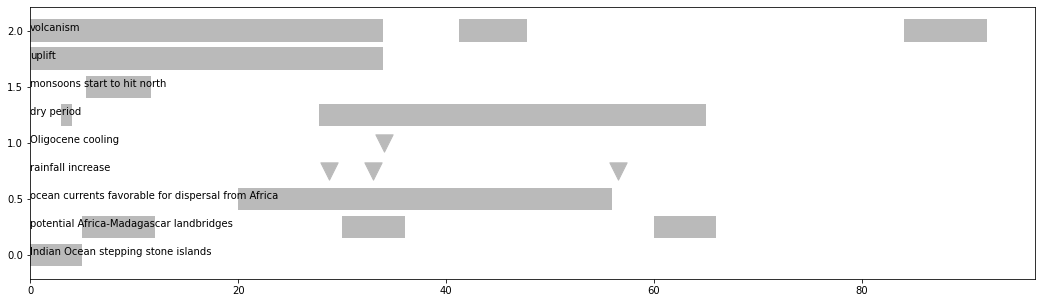

In [25]:
# Note the rainfall increases should be single time points
# (small triangle upwards perhaps, or other symbol) to be consistent with the suppl mat table.
eventbarcolor ='#bababa'

fig,ax=plt.subplots(figsize=(18,5),facecolor='None')

ysh=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax.scatter(x = xmin, y = ysh, s = 300, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax.text(x = 0, y = ysh, s = sh, zorder = 3)
    ysh+=0.25
    
plt.show()

In [26]:
endemic[['early_age','late_age','rand_ma']]

,early_age,late_age,rand_ma
1199,72.1000,66.0,70.00000
1410,72.1000,66.0,67.00000
1936,72.1000,66.0,70.00000
1937,72.1000,66.0,67.00000
1955,72.1000,66.0,69.00000
...,...,...,...
12026,0.0117,0.0,0.00585
12311,72.1000,66.0,68.00000
12773,100.5000,93.9,96.00000
12882,0.0117,0.0,0.00585


In [27]:
dfMGfloat=df[(df['cc'] == 'MG')].copy(deep=True) # for late

       early_age early_bin
1199          72        72
1410          72        72
1936          72        72
1937          72        72
1955          72        72
...          ...       ...
12026          0         0
12311         72        72
12773        100       100
12882          0         0
13075         72        72

[548 rows x 2 columns]
       early_age early_bin
1199          72        72
1410          72        72
1936          72        72
1937          72        72
1955          72        72
...          ...       ...
12026          0         0
12311         72        72
12773        100       100
12882          0         0
13075         72        72

[444 rows x 2 columns]
  early_bin  taxon_name
0         0         191
1         1           0
2         2           0
3         3           0
4         4           0
  early_bin  taxon_name
0         0         157
1         1           0
2         2           0
3         3           0
4         4           0


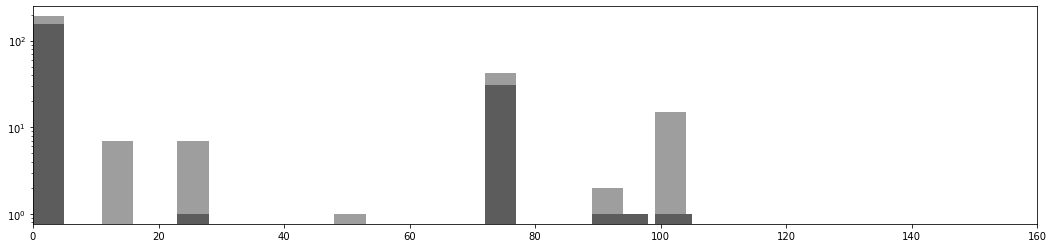

In [28]:
# one year bars

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

dfMG.loc[dfMG.index,'early_age']=dfMG['early_age'].astype('int')
dfMG.loc[dfMG.index,'late_age']=dfMG['late_age'].astype('int')

bins = [x for x in range(0,161,1)]
dfMG['early_bin']=''
dfMG.loc[dfMG.index,'early_bin']=pd.cut(dfMG['early_age'], bins = bins, right = False, include_lowest = True,
                         labels = [x for x in range(0,160,1)])
print(dfMG[['early_age','early_bin']])

## only endemics
endemic = endemic.copy(deep=True)
endemic.loc[endemic.index,'early_age']=endemic['early_age'].astype('int')
endemic.loc[endemic.index,'late_age']=endemic['late_age'].astype('int')

endemic['early_bin']=''
endemic.loc[endemic.index,'early_bin']=pd.cut(endemic['early_age'], bins = bins, right = False, include_lowest = True,
                         labels = [x for x in range(0,160,1)])
print(endemic[['early_age','early_bin']])

# group by unique species
dfMG_byspp=dfMG.groupby('early_bin').nunique()['taxon_name'].reset_index()
print(dfMG_byspp.head())
endemic_byspp=endemic.groupby('early_bin').nunique()['taxon_name'].reset_index()
print(endemic_byspp.head())

fig,ax=plt.subplots(figsize=(18,4),facecolor='w')
ax.set_xlim(0,160)

ax.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 5, align='edge', color = '#9e9e9e')
ax.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 5, align='edge', color = '#5c5c5c')
ax.set_yscale('log')

plt.show()


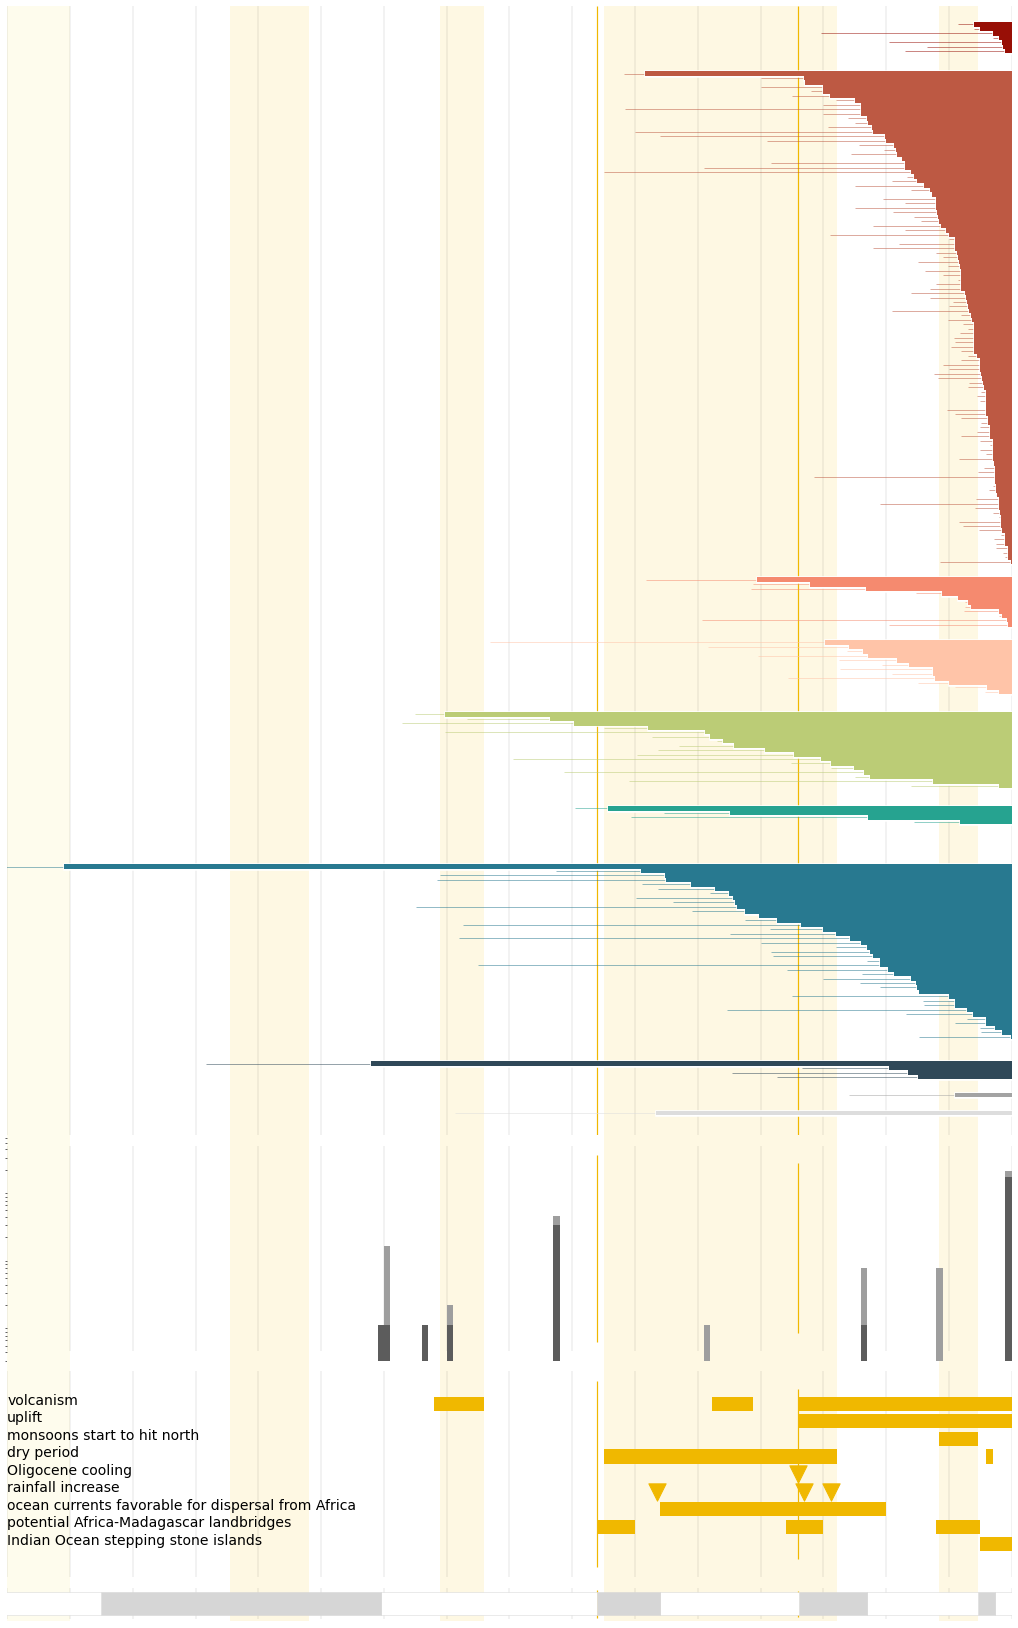

In [29]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(4,1,hspace=0.0,wspace=0.0,
                      height_ratios=[2,0.4,0.4,0.06])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax1=plt.subplot(G[0,0])
ax1.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)


# ------------------------------------------------------------------------- fossil
ax2=plt.subplot(G[1,0])
ax2.set_xlim(xlimmax,0);#plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys()

ax2.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 1, align='edge', color = '#9e9e9e',zorder=20)
ax2.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 1, align='edge', color = '#5c5c5c',zorder=20)
ax2.set_yscale('log')
ax2.grid(axis='y')
# ------------------------------------------------------------------------- EVENTS
ax3=plt.subplot(G[2,0])
ax3.set_xlim(xlimmax,0)

ycat=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax3.scatter(x = xmin, y = ysh, s = 300, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax3.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax3.text(x = xlimmax, y = ysh, s = sh, fontsize = 14, zorder = 3)
    ysh+=0.25

# ------------------------------------------------------------------------- epochs
ax4=plt.subplot(G[3,0])
ax4.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax4.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6',
             facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax4.set_xticks([])
ax4.tick_params(axis='x', colors='w')
[ax4.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot

# ------------------------------------------------------------------------- events yaxis settings
for axx in ax1,ax2,ax3,ax4:
    axx.set_yticks([]);axx.set_xticks([])
    [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# plt.savefig('./Vtemplate_v1_fossils.svg',dpi=300)
plt.show()


Other plants    early_bin  taxon_name
99        99           1
No endemics for Other plants 0
Flowering plants    early_bin  taxon_name
99        99           8
endemic Flowering plants    early_bin  taxon_name
99        99           1
Mammals    early_bin  taxon_name
0          0          76
72        72           3
endemic Mammals    early_bin  taxon_name
0          0          68
72        72           3
Dinosaurs    early_bin  taxon_name
72        72          10
93        93           1
endemic Dinosaurs    early_bin  taxon_name
72        72          10
93        93           1
Reptiles     early_bin  taxon_name
0           0          14
72         72          14
100       100           1
endemic Reptiles     early_bin  taxon_name
0           0          11
72         72          13
100       100           1
Birds    early_bin  taxon_name
0          0          98
72        72           3
endemic Birds    early_bin  taxon_name
0          0          75
72        72           3
Bony fis

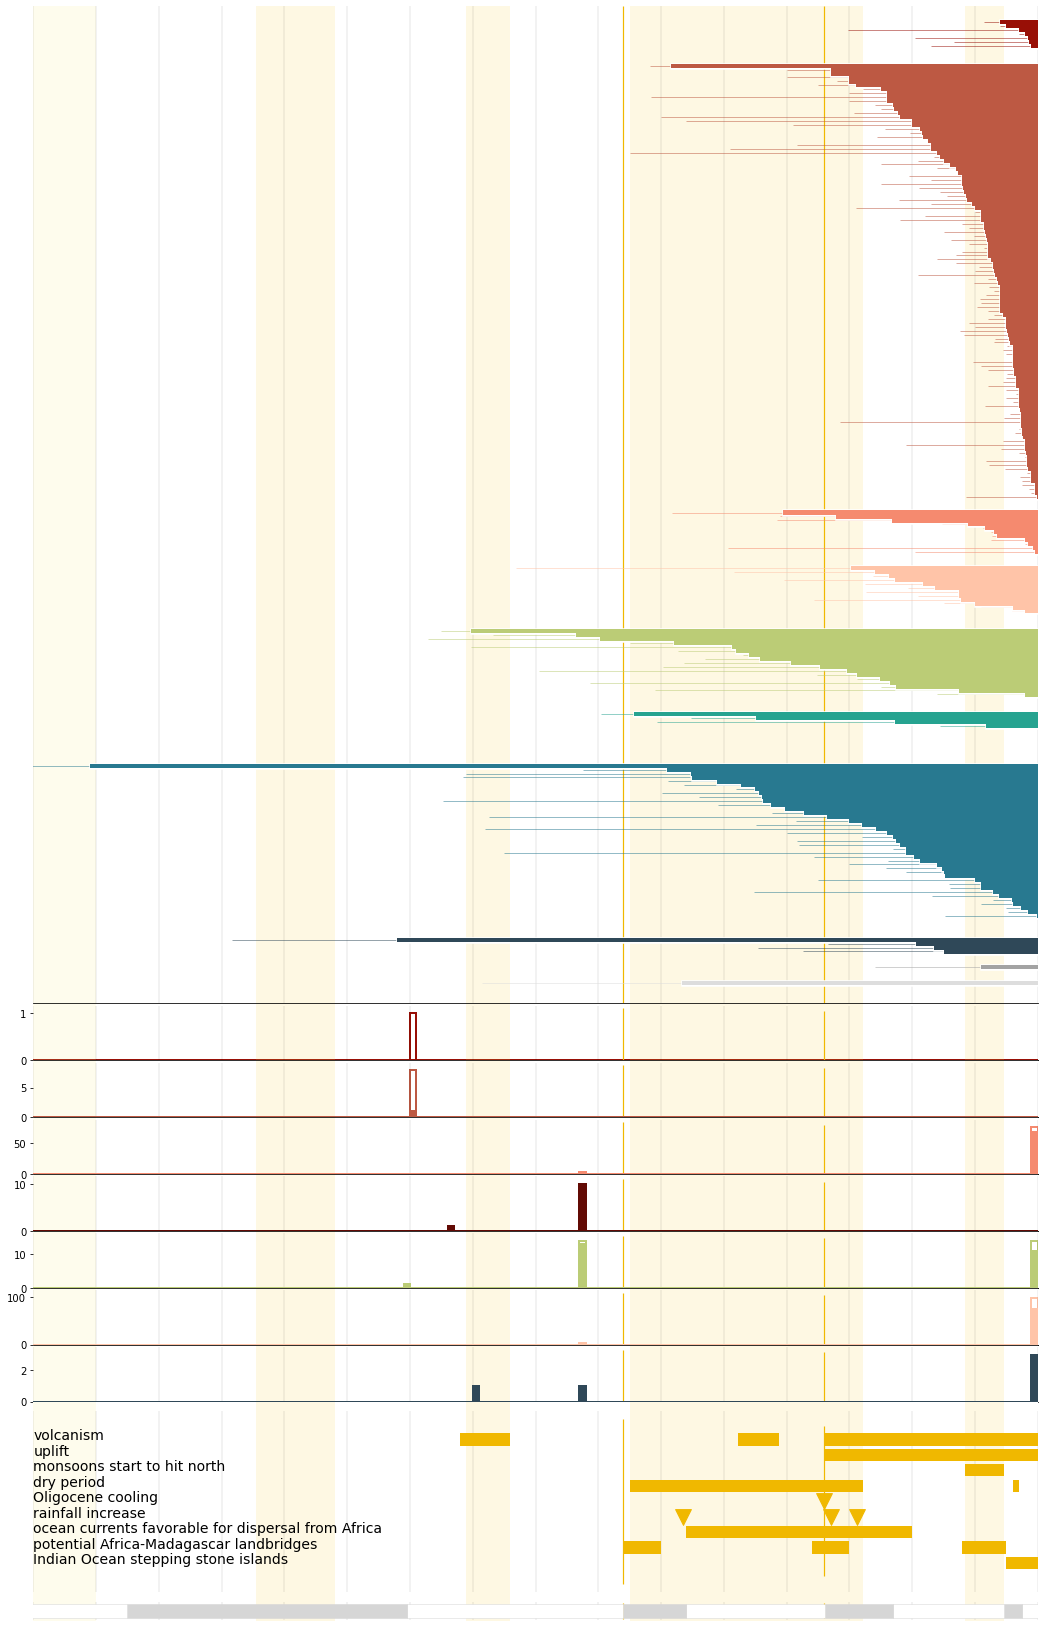

In [34]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(4,1,hspace=0.0,wspace=0.0,
                      height_ratios=[2,0.8,0.4,0.04])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax1=plt.subplot(G[0,0])
ax1.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)


# ------------------------------------------------------------------------- fossil
# ax2=plt.subplot(G[1,0])
# ax2.set_xlim(xlimmax,0);#plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys()

inner_grid = gridspec.GridSpecFromSubplotSpec(len(fossil_order),1,
                                              subplot_spec=plt.subplot(G[1,0]),
                                              hspace=0.0,wspace=0.0)

for index, name in enumerate(fossil_order):
    ax2 = plt.subplot(inner_grid[index,0]) # top row
    ax2.set_xlim(xlimmax,0)
    temp = dfMG[dfMG['common_name'] ==  name]
    
    # group by unique species
    tempgb = temp.groupby('early_bin').nunique()['taxon_name'].reset_index()
    
    ax2.bar(x = tempgb['early_bin'], height = tempgb['taxon_name'], width = 1, align='edge',
            facecolor = 'w', edgecolor = orcoldict[name], zorder = 1, alpha = 1, lw = 2) # bottom = 0,
    print(name,tempgb[tempgb['taxon_name']>0])
    try:
        endemtemp = endemic[endemic['common_name'] ==  name]
        tempendem = endemtemp.groupby('early_bin').nunique()['taxon_name'].reset_index()
        ax2.bar(x = tempendem['early_bin'], height = tempendem['taxon_name'], width = 1, align='edge',
                facecolor = orcoldict[name], edgecolor = orcoldict[name], zorder = 6, alpha = 1, lw = 2) # bottom = 0,
        print('endemic',name,tempendem[tempendem['taxon_name']>0])
    except:
        print('No endemics for %s'%(name), len(endemtemp))
    
    ax2.set_xticks([]); # ax2.set_yticks([]);
    [ax2.spines[loc].set_visible(False) for loc in ['right','left']] # 'bottom','top',
    for key,value in shadeevents.items():
        ax2.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        ax2.vlines(x = value, ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    ax2.vlines(x = [mya for mya in range(0,170,10)], ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)


# ax2.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 5, align='edge', color = '#9e9e9e',zorder=20)
# ax2.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 5, align='edge', color = '#5c5c5c',zorder=20)
# ax2.set_yscale('log')
# ax2.grid(axis='y')
# ------------------------------------------------------------------------- EVENTS
ax3=plt.subplot(G[2,0])
ax3.set_xlim(xlimmax,0)

ycat=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax3.scatter(x = xmin, y = ysh, s = 250, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax3.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax3.text(x = xlimmax, y = ysh, s = sh, fontsize = 14, zorder = 3)
    ysh+=0.25

# ------------------------------------------------------------------------- epochs
ax4=plt.subplot(G[3,0])
ax4.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax4.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6',
             facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax4.set_xticks([])
ax4.tick_params(axis='x', colors='w')
[ax4.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot

# ------------------------------------------------------------------------- events yaxis settings
for axx in ax1,ax3,ax4:
    axx.set_yticks([]);axx.set_xticks([])
    [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# plt.savefig('./Vtemplate_v3_fossils.svg',dpi=300)
plt.show()


In [ ]:
# five year bars

       early_age early_bin
1199          72        70
1410          72        70
1936          72        70
1937          72        70
1955          72        70
...          ...       ...
12026          0         0
12311         72        70
12773        100       100
12882          0         0
13075         72        70

[548 rows x 2 columns]
       early_age early_bin
1199          72        70
1410          72        70
1936          72        70
1937          72        70
1955          72        70
...          ...       ...
12026          0         0
12311         72        70
12773        100       100
12882          0         0
13075         72        70

[444 rows x 2 columns]
  early_bin  taxon_name
0         0         191
1         5           0
2        10           7
3        15           0
4        20           7
  early_bin  taxon_name
0         0         157
1         5           0
2        10           0
3        15           0
4        20           1


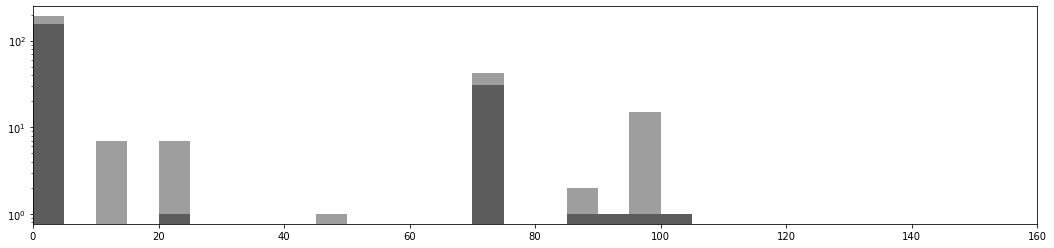

In [45]:
dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

dfMG.loc[dfMG.index,'early_age']=dfMG['early_age'].astype('int')
dfMG.loc[dfMG.index,'late_age']=dfMG['late_age'].astype('int')

bins = [x for x in range(0,165,5)]
dfMG['early_bin']=''
dfMG.loc[dfMG.index,'early_bin']=pd.cut(dfMG['early_age'], bins = bins, right = False, include_lowest = True,
                         labels = [x for x in range(0,160,5)])
print(dfMG[['early_age','early_bin']])

## only endemics
endemic = endemic.copy(deep=True)
endemic.loc[endemic.index,'early_age']=endemic['early_age'].astype('int')
endemic.loc[endemic.index,'late_age']=endemic['late_age'].astype('int')

endemic['early_bin']=''
endemic.loc[endemic.index,'early_bin']=pd.cut(endemic['early_age'], bins = bins, right = False, include_lowest = True,
                         labels = [x for x in range(0,160,5)])
print(endemic[['early_age','early_bin']])

# group by unique species
dfMG_byspp=dfMG.groupby('early_bin').nunique()['taxon_name'].reset_index()
print(dfMG_byspp.head())
endemic_byspp=endemic.groupby('early_bin').nunique()['taxon_name'].reset_index()
print(endemic_byspp.head())

fig,ax=plt.subplots(figsize=(18,4),facecolor='w')
ax.set_xlim(0,160)

ax.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 5, align='edge', color = '#9e9e9e')
ax.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 5, align='edge', color = '#5c5c5c')
ax.set_yscale('log')

plt.show()

In [46]:
dfMG[['early_age','late_age']].isna().describe()

,early_age,late_age
count,548,548
unique,1,1
top,False,False
freq,548,548


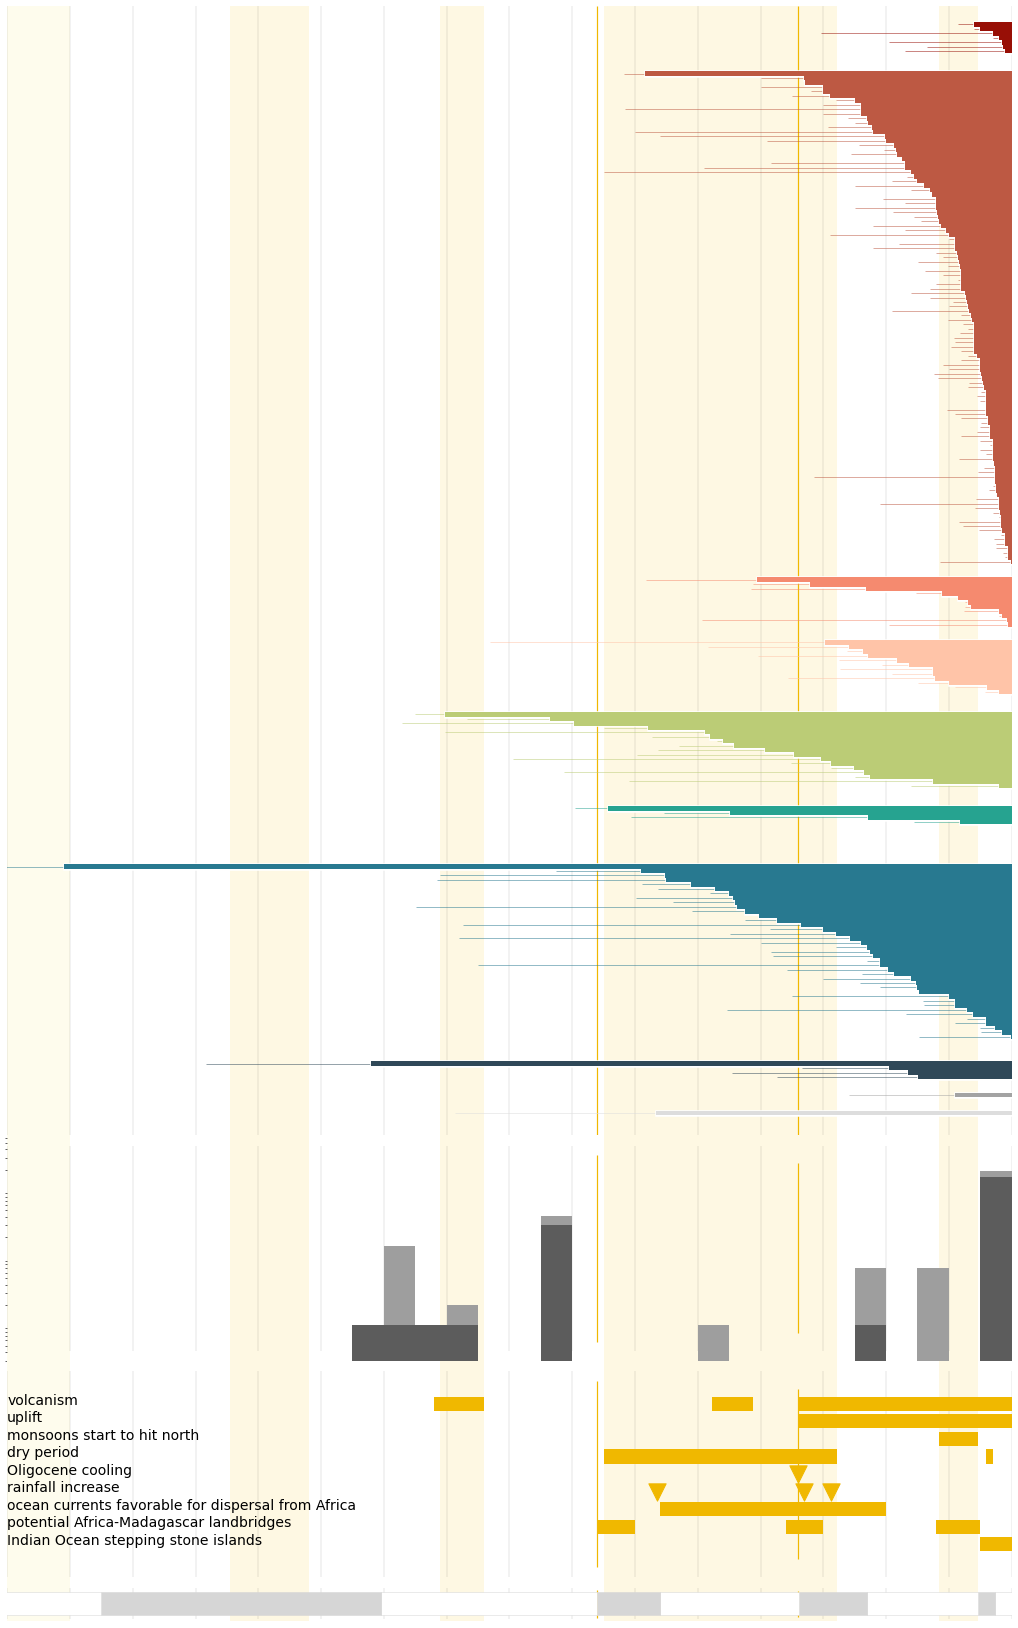

In [47]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(4,1,hspace=0.0,wspace=0.0,
                      height_ratios=[2,0.4,0.4,0.06])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax1=plt.subplot(G[0,0])
ax1.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)


# ------------------------------------------------------------------------- fossil
ax2=plt.subplot(G[1,0])
ax2.set_xlim(xlimmax,0);#plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys()

ax2.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 5, align='edge', color = '#9e9e9e',zorder=20)
ax2.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 5, align='edge', color = '#5c5c5c',zorder=20)
ax2.set_yscale('log')
ax2.grid(axis='y')
# ------------------------------------------------------------------------- EVENTS
ax3=plt.subplot(G[2,0])
ax3.set_xlim(xlimmax,0)

ycat=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax3.scatter(x = xmin, y = ysh, s = 300, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax3.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax3.text(x = xlimmax, y = ysh, s = sh, fontsize = 14, zorder = 3)
    ysh+=0.25

# ------------------------------------------------------------------------- epochs
ax4=plt.subplot(G[3,0])
ax4.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax4.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6',
             facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax4.set_xticks([])
ax4.tick_params(axis='x', colors='w')
[ax4.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot

# ------------------------------------------------------------------------- events yaxis settings
for axx in ax1,ax2,ax3,ax4:
    axx.set_yticks([]);axx.set_xticks([])
    [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# plt.savefig('./Vtemplate_v1_fossils.svg',dpi=300)
plt.show()


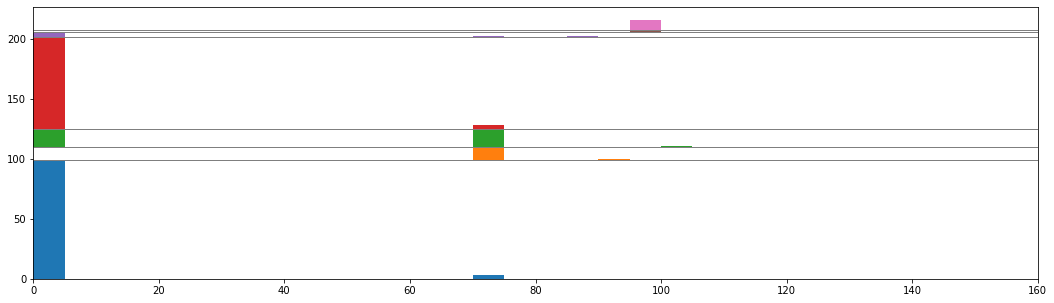

In [48]:
fig,ax = plt.subplots(figsize=(18,5),facecolor='None')
ax.set_xlim(0,160)
ybase = 0
for name in dfMG['common_name'].dropna().unique():
    temp = dfMG[dfMG['common_name'] ==  name]
    
    try:
        # group by unique species
        tempgb = temp.groupby('early_bin').nunique()['taxon_name'].reset_index()

        ax.bar(x = tempgb['early_bin'], height = tempgb['taxon_name'], bottom = ybase, width = 5, align='edge')
        ax.hlines(y = ybase, xmin = 0, xmax = 160, color = 'k', lw=0.5)
        ybase += tempgb['taxon_name'].max() + 1
    except:
        print('Plotting of %s fails with DF lenght %s'%(name,len(temp)))
# plt.yscale('log')
plt.show()

In [49]:
dfMG['common_name'].dropna().unique()
fossil_order=['Other plants', 'Flowering plants','Mammals','Dinosaurs', 'Birds', 'Reptiles', 'Bony fishes']

No endemics for Other plants 0


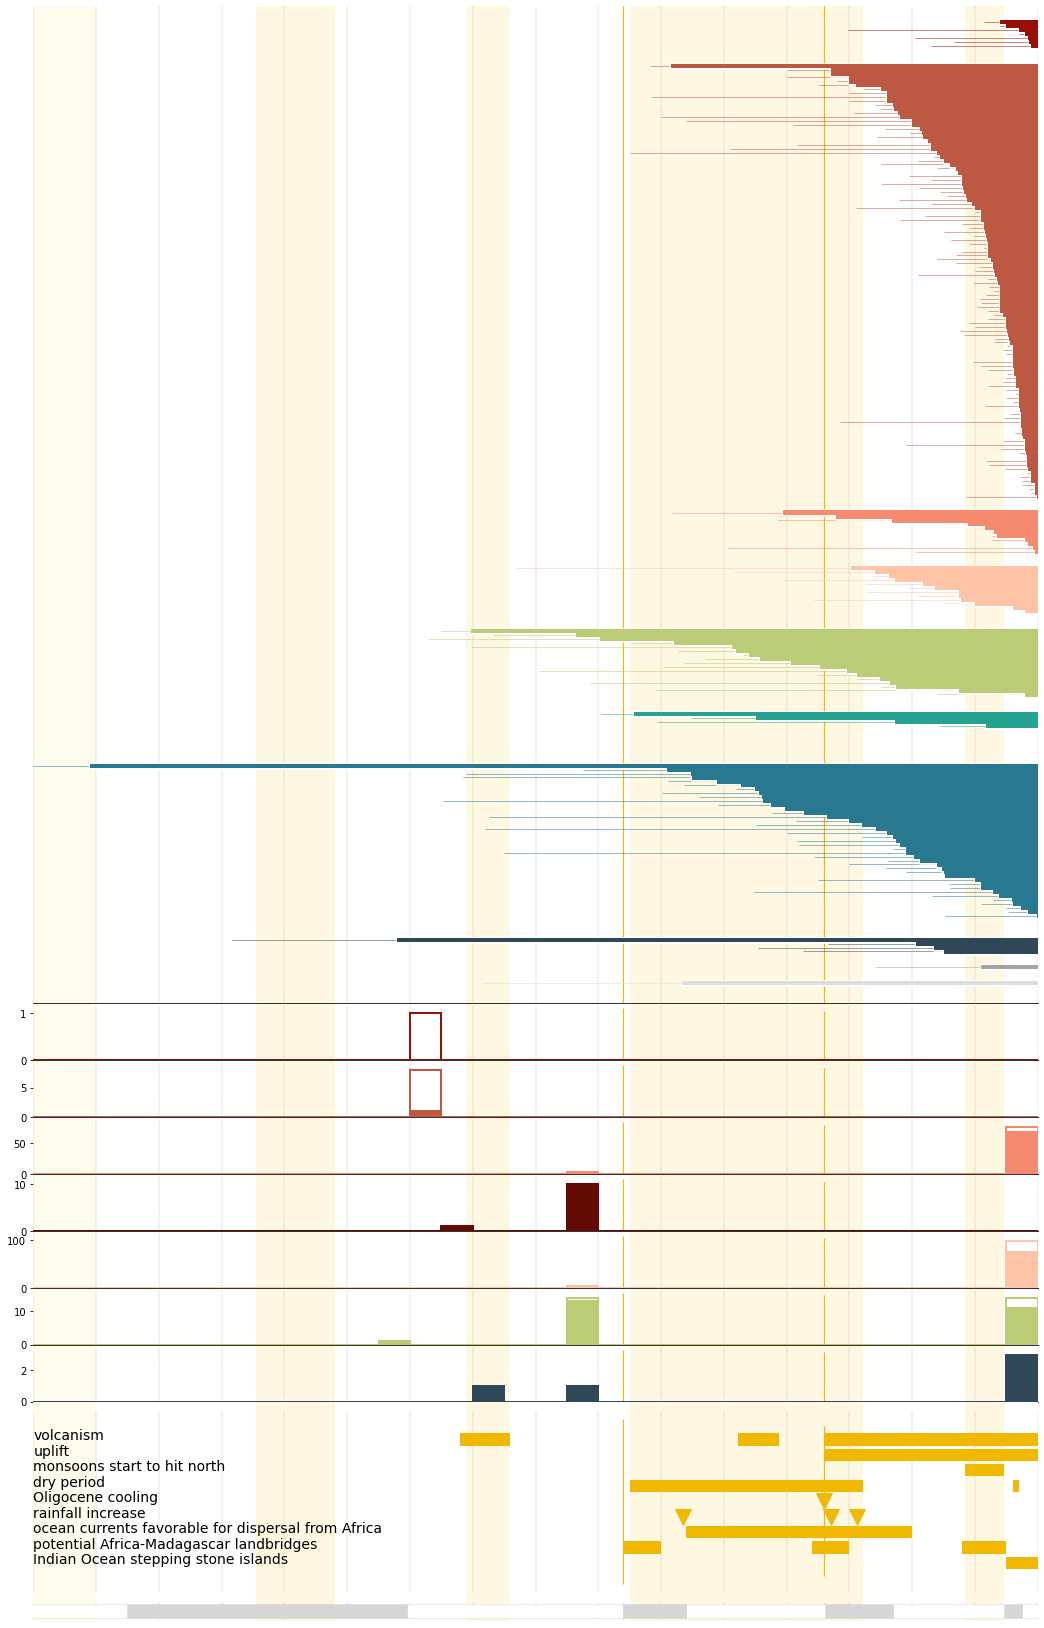

In [50]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(4,1,hspace=0.0,wspace=0.0,
                      height_ratios=[2,0.8,0.4,0.04])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax1=plt.subplot(G[0,0])
ax1.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)


# ------------------------------------------------------------------------- fossil
# ax2=plt.subplot(G[1,0])
# ax2.set_xlim(xlimmax,0);#plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys()

inner_grid = gridspec.GridSpecFromSubplotSpec(len(fossil_order),1,
                                              subplot_spec=plt.subplot(G[1,0]),
                                              hspace=0.0,wspace=0.0)

for index, name in enumerate(fossil_order):
    ax2 = plt.subplot(inner_grid[index,0]) # top row
    ax2.set_xlim(xlimmax,0)
    temp = dfMG[dfMG['common_name'] ==  name]
    
    # group by unique species
    tempgb = temp.groupby('early_bin').nunique()['taxon_name'].reset_index()
    
    ax2.bar(x = tempgb['early_bin'], height = tempgb['taxon_name'], width = 5, align='edge',
            facecolor = 'w', edgecolor = orcoldict[name], zorder = 5, alpha = 1, lw = 2) # bottom = 0,
    try:
        endemtemp = endemic[endemic['common_name'] ==  name]
        tempendem = endemtemp.groupby('early_bin').nunique()['taxon_name'].reset_index()
        ax2.bar(x = tempendem['early_bin'], height = tempendem['taxon_name'], width = 5, align='edge',
                facecolor = orcoldict[name], edgecolor = orcoldict[name], zorder = 6, alpha = 1, lw = 2) # bottom = 0,
    except:
        print('No endemics for %s'%(name), len(endemtemp))
    
    ax2.set_xticks([]); # ax2.set_yticks([]);
    [ax2.spines[loc].set_visible(False) for loc in ['right','left']] # 'bottom','top',
    for key,value in shadeevents.items():
        ax2.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        ax2.vlines(x = value, ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    ax2.vlines(x = [mya for mya in range(0,170,10)], ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)


# ax2.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 5, align='edge', color = '#9e9e9e',zorder=20)
# ax2.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 5, align='edge', color = '#5c5c5c',zorder=20)
# ax2.set_yscale('log')
# ax2.grid(axis='y')
# ------------------------------------------------------------------------- EVENTS
ax3=plt.subplot(G[2,0])
ax3.set_xlim(xlimmax,0)

ycat=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax3.scatter(x = xmin, y = ysh, s = 250, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax3.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax3.text(x = xlimmax, y = ysh, s = sh, fontsize = 14, zorder = 3)
    ysh+=0.25

# ------------------------------------------------------------------------- epochs
ax4=plt.subplot(G[3,0])
ax4.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax4.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6',
             facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax4.set_xticks([])
ax4.tick_params(axis='x', colors='w')
[ax4.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot

# ------------------------------------------------------------------------- events yaxis settings
for axx in ax1,ax3,ax4:
    axx.set_yticks([]);axx.set_xticks([])
    [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# plt.savefig('./Vtemplate_v1_fossils.svg',dpi=300)
plt.show()


In [40]:
# keep year as integer (1 mya categories)

dfMGfloat[['taxon_name','early_age']]
dfMGbybin = dfMGfloat.groupby('early_age').nunique()['taxon_name'].reset_index()
dfMGbybin

,early_age,taxon_name
0,0.0117,153
1,0.1260,70
2,11.6200,7
3,23.0300,7
4,48.6000,1
5,72.1000,59
6,89.8000,2
7,93.9000,1
8,99.6000,15
9,100.5000,1


In [45]:
# grouping means early age category with no species
# to plot this as lines without producing misleading slopes I need to add the zero-filled categories
# new_age=[x for x in range(0,161,1) if x not in dfMGbybin['early_age'].values]
new_age=[x for x in np.arange(0,161,0.1) if x not in dfMGbybin['early_age'].values]

new_age
empties=pd.DataFrame(list(zip(new_age,[0]*len(new_age))),
                    columns=['early_age','taxon_name'])
empties
# concatenate empites and dfMGbybin
dfMGbybin=pd.concat([dfMGbybin,empties], sort=True)
dfMGbybin.sort_values(by='early_age', ascending = True, inplace=True)
dfMGbybin.reset_index(inplace=True)
dfMGbybin

,level_0,early_age,index,taxon_name
0,0,0.0000,0.0,0
1,1,0.0117,0.0,153
2,0,0.1000,NaN,0
3,2,0.1260,1.0,70
4,1,0.2000,NaN,0
...,...,...,...,...
1612,1441,160.5000,NaN,0
1613,1442,160.6000,NaN,0
1614,1443,160.7000,NaN,0
1615,1444,160.8000,NaN,0


In [46]:
# .rolling(3).mean() # sum by 5 Mya windows
dfMGbybin['taxon_name'].rolling(5).sum()

0         NaN
1         NaN
2         NaN
3         NaN
4       223.0
        ...  
1612      0.0
1613      0.0
1614      0.0
1615      0.0
1616      0.0
Name: taxon_name, Length: 1617, dtype: float64

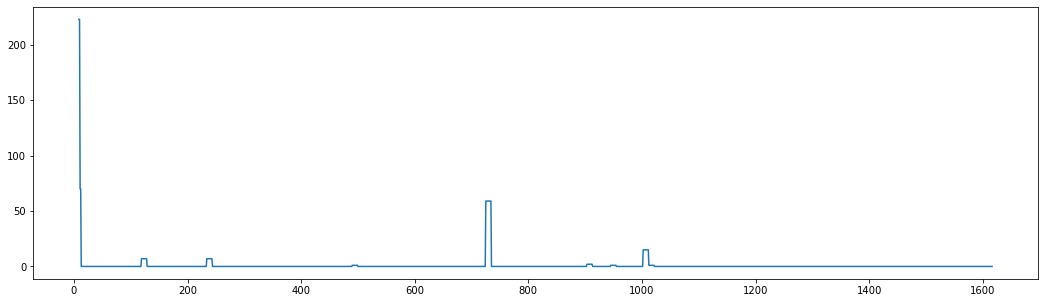

In [48]:
# plotting total fossils
fig,ax = plt.subplots(figsize=(18,5),facecolor='None')
ax.plot(dfMGbybin['taxon_name'].rolling(10).sum())
plt.show()

No endemics for Other plants 0


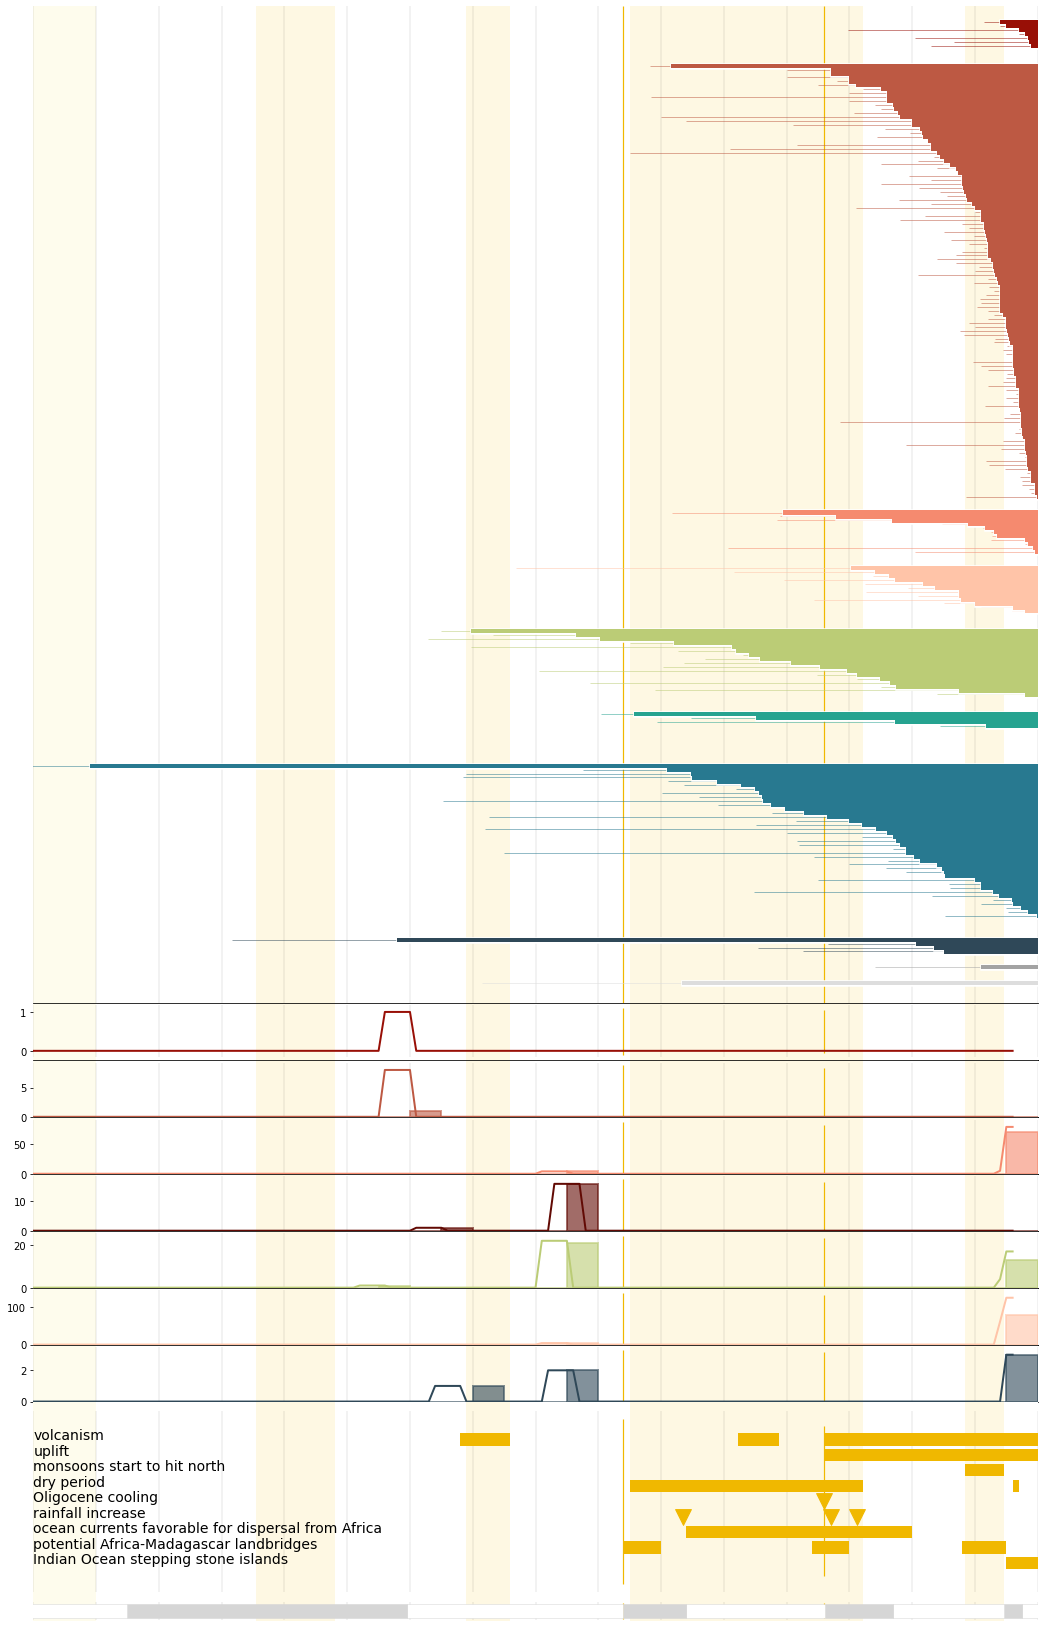

In [52]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(4,1,hspace=0.0,wspace=0.0,
                      height_ratios=[2,0.8,0.4,0.04])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax1=plt.subplot(G[0,0])
ax1.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)


# ------------------------------------------------------------------------- fossil
# ax2=plt.subplot(G[1,0])
# ax2.set_xlim(xlimmax,0);#plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys()

inner_grid = gridspec.GridSpecFromSubplotSpec(len(fossil_order),1,
                                              subplot_spec=plt.subplot(G[1,0]),
                                              hspace=0.0,wspace=0.0)

for index, name in enumerate(fossil_order):
    ax2 = plt.subplot(inner_grid[index,0]) # top row
    ax2.set_xlim(xlimmax,0)
    temp = dfMGfloat[dfMGfloat['common_name'] ==  name]
    
    # group by unique species
    tempgb = temp.groupby('early_age').nunique()['taxon_name'].reset_index()
    
    new_age=[x for x in range(0,161,1) if x not in tempgb['early_age'].values]
#     new_age=[x for x in np.arange(0,161,0.1) if x not in tempgb['early_age'].values]
    empties=pd.DataFrame(list(zip(new_age,[0]*len(new_age))),
                        columns=['early_age','taxon_name'])
    # concatenate empites and tempgb
    tempgb=pd.concat([tempgb,empties], sort=True)
    tempgb.sort_values(by='early_age', ascending = True, inplace=True)
    tempgb.reset_index(inplace=True)
    
    ax2.plot(tempgb['taxon_name'].rolling(5).sum(), color = orcoldict[name], zorder = 5, alpha = 1, lw = 2)

    try:
        endemtemp = endemic[endemic['common_name'] ==  name]
        tempendem = endemtemp.groupby('early_bin').nunique()['taxon_name'].reset_index()
        ax2.bar(x = tempendem['early_bin'], height = tempendem['taxon_name'], width = 5, align='edge',
                facecolor = orcoldict[name], edgecolor = orcoldict[name], zorder = 6, alpha = 0.6, lw = 2) # bottom = 0,
    except:
        print('No endemics for %s'%(name), len(endemtemp))
    
    ax2.set_xticks([]); # ax2.set_yticks([]);
    [ax2.spines[loc].set_visible(False) for loc in ['right','left']] # 'bottom','top',
    for key,value in shadeevents.items():
        ax2.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        ax2.vlines(x = value, ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    ax2.vlines(x = [mya for mya in range(0,170,10)], ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)


# ax2.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 5, align='edge', color = '#9e9e9e',zorder=20)
# ax2.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 5, align='edge', color = '#5c5c5c',zorder=20)
# ax2.set_yscale('log')
# ax2.grid(axis='y')
# ------------------------------------------------------------------------- EVENTS
ax3=plt.subplot(G[2,0])
ax3.set_xlim(xlimmax,0)

ycat=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax3.scatter(x = xmin, y = ysh, s = 250, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax3.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax3.text(x = xlimmax, y = ysh, s = sh, fontsize = 14, zorder = 3)
    ysh+=0.25

# ------------------------------------------------------------------------- epochs
ax4=plt.subplot(G[3,0])
ax4.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax4.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6',
             facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax4.set_xticks([])
ax4.tick_params(axis='x', colors='w')
[ax4.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot

# ------------------------------------------------------------------------- events yaxis settings
for axx in ax1,ax3,ax4:
    axx.set_yticks([]);axx.set_xticks([])
    [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# plt.savefig('./Vtemplate_v1_fossils.svg',dpi=300)
plt.show()


No endemics for Other plants 0
Empty DataFrame
Columns: [index, occurrence_no, record_type, collection_no, taxon_name, taxon_rank, taxon_no, matched_name, matched_rank, matched_no, early_interval, early_age, late_age, reference_no, genus_name, species_name, genus, genus_no, family, family_no, order, order_no, class, class_no, phylum, phylum_no, lng, lat, cc, paleolng, paleolat, geoplate, early_age.1, late_age.1, cx_int_no, early_int_no, late_int_no, stratcomments, state, geogscale, formation, formation.1, stratscale, localsection, member, member.1, county, late_interval, stratgroup, stratgroup.1, localbed, zone, species_reso, genus_reso, localorder, reid_no, regionalsection, regionalbed, regionalorder, subgenus_name, subgenus_reso, delta_ma, mean_ma, rand_ma, common_name, early_bin]
Index: []

[0 rows x 66 columns]


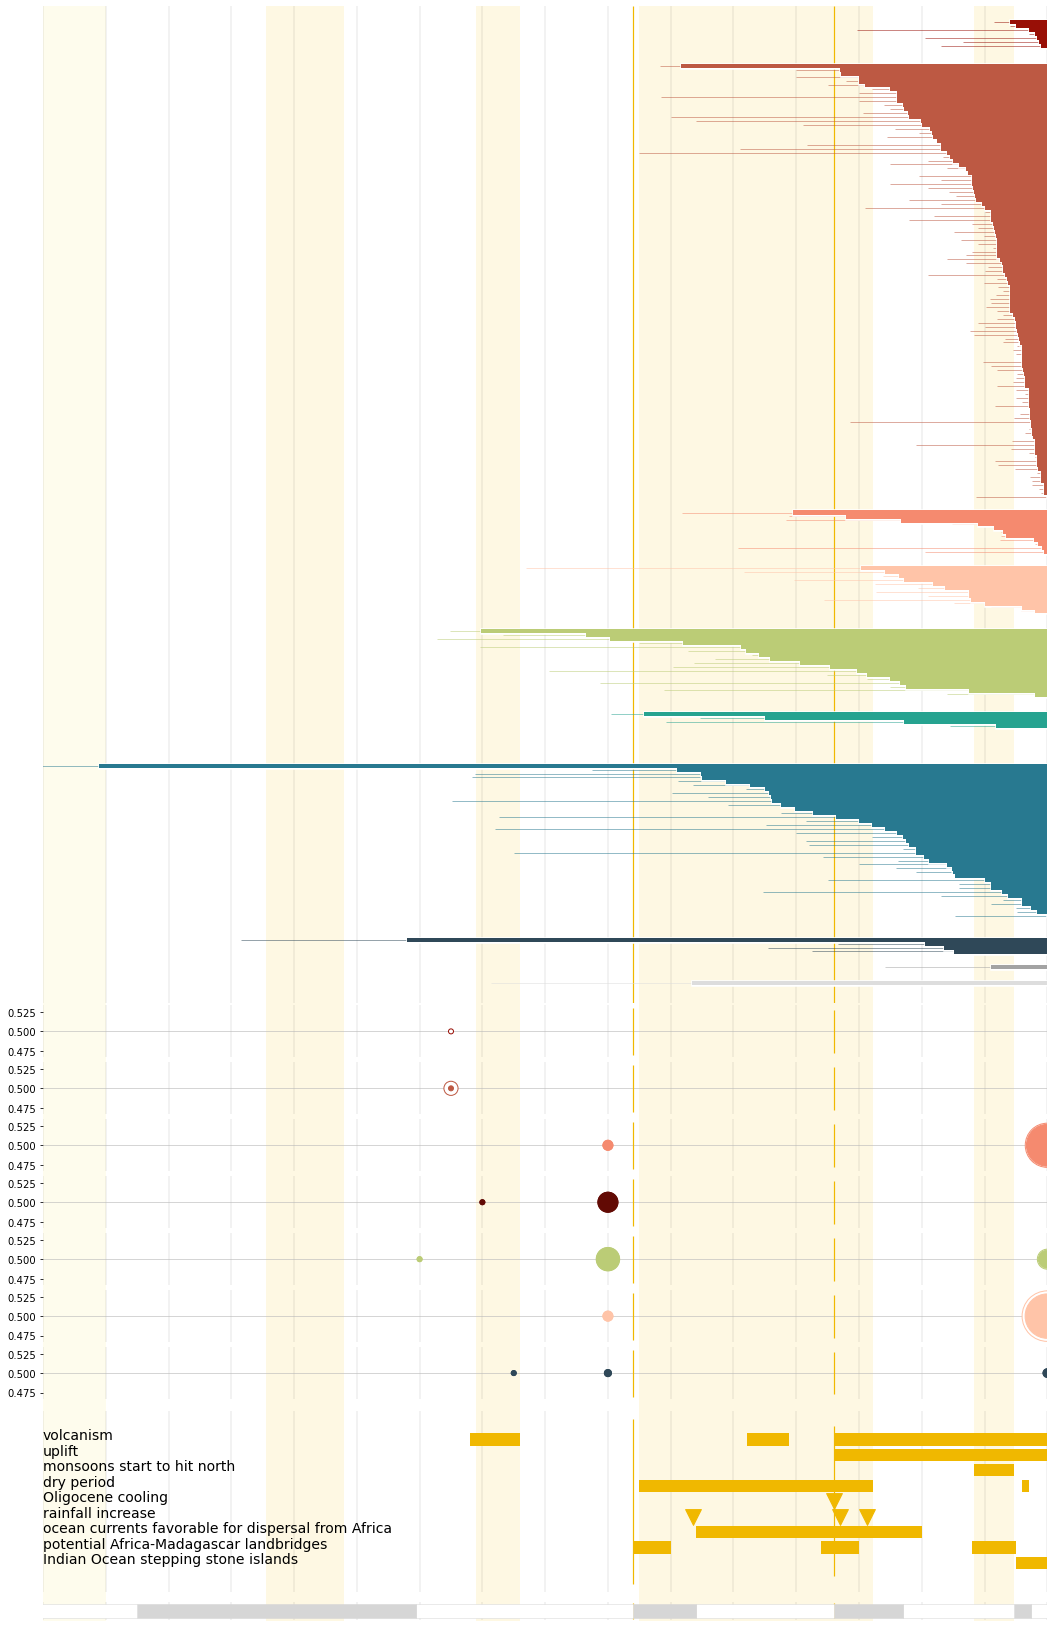

In [67]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(4,1,hspace=0.0,wspace=0.0,
                      height_ratios=[2,0.8,0.4,0.04])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax1=plt.subplot(G[0,0])
ax1.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)


# ------------------------------------------------------------------------- fossil
inner_grid = gridspec.GridSpecFromSubplotSpec(len(fossil_order),1,
                                              subplot_spec=plt.subplot(G[1,0]),
                                              hspace=0.0,wspace=0.0)

for index, name in enumerate(fossil_order):
    ax2 = plt.subplot(inner_grid[index,0]) # top row
    ax2.set_xlim(xlimmax,0)
    temp = dfMG[dfMG['common_name'] ==  name]
    
    # group by unique species
    tempgb = temp.groupby('early_bin').nunique()['taxon_name'].reset_index()
    
    ax2.scatter(x = tempgb['early_bin'], y = [0.5]*len(tempgb['taxon_name']),
                facecolor = 'w', edgecolor = orcoldict[name], zorder = 5, alpha = 1,
                s = tempgb['taxon_name'] * 25)
    ax2.hlines(y=0.5, xmin = ax2.get_xlim()[0], xmax = ax2.get_xlim()[1], color = '#bababa', zorder = 2, lw = 0.6)

    try:
        endemtemp = endemic[endemic['common_name'] ==  name]
        tempendem = endemtemp.groupby('early_bin').nunique()['taxon_name'].reset_index()

        ax2.scatter(x = tempendem['early_bin'], y = [0.5]*len(tempendem['taxon_name']),
                    facecolor = orcoldict[name], edgecolor = orcoldict[name],
                    zorder = 5, alpha = 1, s = tempendem['taxon_name'] * 25)
    except:
        print('No endemics for %s'%(name), len(endemtemp))
        print(endemtemp)
    
    ax2.set_xticks([]); # ax2.set_yticks([]);
    [ax2.spines[loc].set_visible(False) for loc in ['bottom','top','right','left']] # 'bottom','top',
    for key,value in shadeevents.items():
        ax2.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        ax2.vlines(x = value, ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    ax2.vlines(x = [mya for mya in range(0,170,10)], ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# ------------------------------------------------------------------------- EVENTS
ax3=plt.subplot(G[2,0])
ax3.set_xlim(xlimmax,0)

ycat=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax3.scatter(x = xmin, y = ysh, s = 250, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax3.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax3.text(x = xlimmax, y = ysh, s = sh, fontsize = 14, zorder = 3)
    ysh+=0.25

# ------------------------------------------------------------------------- epochs
ax4=plt.subplot(G[3,0])
ax4.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax4.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6',
             facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax4.set_xticks([])
ax4.tick_params(axis='x', colors='w')
[ax4.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot

# ------------------------------------------------------------------------- events yaxis settings
for axx in ax1,ax3,ax4:
    axx.set_yticks([]);axx.set_xticks([])
    [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# plt.savefig('./Vtemplate_v1_fossils.svg',dpi=300)
plt.show()


In [ ]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(4,1,hspace=0.0,wspace=0.0,
                      height_ratios=[2,0.8,0.4,0.04])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax1=plt.subplot(G[0,0])
ax1.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax1, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)


# ------------------------------------------------------------------------- fossil
# ax2=plt.subplot(G[1,0])
# ax2.set_xlim(xlimmax,0);#plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys()

col='late_age'

inner_grid = gridspec.GridSpecFromSubplotSpec(len(fossil_order),1,
                                              subplot_spec=plt.subplot(G[1,0]),
                                              hspace=0.0,wspace=0.0)

for index, name in enumerate(fossil_order):
    ax2 = plt.subplot(inner_grid[index,0]) # top row
    ax2.set_xlim(xlimmax,0)
    temp = dfMG[dfMG['common_name'] ==  name]
    
    # group by unique species
    tempgb = temp.groupby(col).nunique()['taxon_name'].reset_index()
    
    new_age=[x for x in range(0,161,1) if x not in tempgb[col].values]
    empties=pd.DataFrame(list(zip(new_age,[0]*len(new_age))),
                        columns=[col,'taxon_name'])
    
    # concatenate empites and tempgb
    tempgb=pd.concat([tempgb,empties], sort=True)
    tempgb.sort_values(by=col, ascending = True, inplace=True)
    tempgb.reset_index(inplace=True)
    
    ax2.plot(tempgb['taxon_name'].rolling(1).sum(), color = orcoldict[name], zorder = 5, alpha = 1, lw = 2)

    try:
        endemtemp = endemic[endemic['common_name'] ==  name]
        tempendem = endemtemp.groupby('late_bin').nunique()['taxon_name'].reset_index()
        ax2.bar(x = tempendem['late_bin'], height = tempendem['taxon_name'], width = 5, align='edge',
                facecolor = orcoldict[name], edgecolor = orcoldict[name], zorder = 6, alpha = 0.6, lw = 2) # bottom = 0,
    except:
        print('No endemics for %s'%(name), len(endemtemp))
    
    ax2.set_xticks([]); # ax2.set_yticks([]);
    [ax2.spines[loc].set_visible(False) for loc in ['right','left']] # 'bottom','top',
    for key,value in shadeevents.items():
        ax2.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        ax2.vlines(x = value, ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    ax2.vlines(x = [mya for mya in range(0,170,10)], ymin = ax2.get_ylim()[0], ymax = ax2.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)


# ax2.bar(x = dfMG_byspp['early_bin'], height = dfMG_byspp['taxon_name'], width = 5, align='edge', color = '#9e9e9e',zorder=20)
# ax2.bar(x = endemic_byspp['early_bin'], height = endemic_byspp['taxon_name'], width = 5, align='edge', color = '#5c5c5c',zorder=20)
# ax2.set_yscale('log')
# ax2.grid(axis='y')
# ------------------------------------------------------------------------- EVENTS
ax3=plt.subplot(G[2,0])
ax3.set_xlim(xlimmax,0)

ycat=0
for sh in bars.sort_values('type', ascending=True)['short'].unique():
    temp1list = list(zip(bars[bars['short'] == sh]['time_Ma_to'],
                         bars[bars['short'] == sh]['time_Ma_from']))
    for event in temp1list:
        xmax=event[1]
        xmin=event[0]
#         print(xmin,xmax,sh)
        if str(sh) in ['rainfall increase','Oligocene cooling']:
            ax3.scatter(x = xmin, y = ysh, s = 250, marker = 'v', color = eventbarcolor, zorder = 2)
        else:
            ax3.barh(y = ysh, width = xmax - xmin, height = 0.2, 
                    left = xmin, align = 'center', edgecolor = 'none', facecolor = eventbarcolor,
                    lw = 2, alpha = 1, color = 'w', zorder = 2)
    ax3.text(x = xlimmax, y = ysh, s = sh, fontsize = 14, zorder = 3)
    ysh+=0.25

# ------------------------------------------------------------------------- epochs
ax4=plt.subplot(G[3,0])
ax4.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax4.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6',
             facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax4.set_xticks([])
ax4.tick_params(axis='x', colors='w')
[ax4.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot

# ------------------------------------------------------------------------- events yaxis settings
for axx in ax1,ax3,ax4:
    axx.set_yticks([]);axx.set_xticks([])
    [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

# plt.savefig('./Vtemplate_v1_fossils.svg',dpi=300)
plt.show()


In [ ]:
cleandf[cleandf['common_name'] == 'Other plants'].groupby(by='timebin')[unit].count().reset_index().max()

In [ ]:
# fossil_order
np.log(81)

----

# 6. Plotting holocene events

----  

In [ ]:
holocene = pd.read_csv('./new_holocene_shades.txt', sep ='\t')
holocene.sort_values(by = 'start_ka_bp', ascending = False, inplace = True)
print(holocene.type.unique())
holocene_order = ['climate','vegetation','human arrival','introductions','last record']
holo_col = {'climate':'#f0b800',
            'vegetation':'#c08f00',
            'human arrival':'#916800',
            'introductions':'#674300',
           'last record':'#999999'}

print(holocene.groupby(by = 'type')['description'].count())
holocene.sort_values(by = 'type')

line_events = {'Mammal extinction rate increase':2,
              'European arrival':0.5,
              'Robust evidence for human presence':2} # removed from list
last_records = {'hippopotamus':0.950,
               'elephant birds':0.840,
               'giant tortoise':0.750,
               'giant lemurs':0.585}
holocene

In [ ]:
plt.figure(figsize=(8,5),facecolor='None')
G = gridspec.GridSpec(1,6,hspace=0.0,wspace=0.0, width_ratios =[0.6,0.8,0.8,2,6,8])
text_color='#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(round(holocene['start_ka_bp'].max()),0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax1.set_xticks([])

for i,event in enumerate(holocene_order):
    print(i,event)
    ax=plt.subplot(G[0,i + 1])
    ax.set_ylim(round(holocene['start_ka_bp'].max()),0)
    
    temp = holocene[holocene.type == event]
    xbase = 0
    for row in temp.itertuples():
        height = row.start_ka_bp - row.end_ka_bp
        width = 0.2
        bottom = row.end_ka_bp
        ax.bar(x = xbase, height = height, width = width, bottom = bottom, align = 'center', facecolor = holo_col[event], edgecolor = 'w', lw = 1, alpha = 1, zorder = 4)
        xbase += 0.3
    if event == 'last record':
        ax.set_xlim(-0.09,1)
        xpos = 0.0
        for key,values in last_records.items():
            ax.hlines(y = values, xmin = xpos - 0.08, xmax = xpos+0.02, color = '#999999', lw = 4, ls = '-', zorder = 4)
            xpos += 0.15
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),2)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    ax.set_yticks([])

# plt.savefig('./holocene4.svg',dpi=300)
plt.show()


----

# 7. Taxon origin, tree maps, and origine uncertainty

----

## 7.1. Counting proportions

In [ ]:
# set shows groups and counts items inside each group (set theory)
set(sum([x for x in extant['origin_plot'].str.split('\/')],[])) # two or more origins are writen and separated by a '/'

# lineage origin color dictionary
origins_uncert = ['Africa_Certain', 'Africa_Uncertain', 'Eurasia_Certain', 'Eurasia_Uncertain',
           'Indopacific_Certain', 'Indopacific_Uncertain', 'Neotropics_Certain', 'Neotropics_Uncertain',
           'North America_Certain', 'North America_Uncertain']
# generates a colour for each key in the dictionary above
orcoldictunique = colourDict(origins_uncert, cmap=mpl.cm.tab20c, sort = False)
# adds key,colour to colour dictionary
orcoldictunique['Unknown_Certain'] = '#ffffff'
orcoldictunique

In [ ]:
import plotly.express as px

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    parents = []
    labels = []
    colors = []
    contribution = []
    print('%s'%('plants' if dataframe is plantdf else 'animals'))
    for row in dataframe.itertuples():
        if '/' in row.origin_plot:
            for i in row.origin_plot.split('/'):
                parents.append(i)
                labels.append('Uncertain')
                colors.append(orcoldictunique['%s_Uncertain'%(i)])
                contribution.append(1/(len(row.origin_plot)))
        else:
            parents.append(row.origin_plot)
            labels.append('Certain')
            colors.append(orcoldictunique['%s_Certain'%(row.origin_plot)])
            contribution.append(1)
    ordata = pd.DataFrame(list(zip(parents,labels,colors,contribution)),columns = ['parents','labels','colors','contribution'])
    print(ordata.groupby(by = ['parents','labels'])['contribution'].sum().reset_index())
    
    fig = px.treemap(ordata, path = ['parents', 'labels'], values = 'contribution', color = 'parents', width = 700, height = 700, branchvalues = 'total', hover_data = {'parents':False})
    fig.update_layout(uniformtext = dict(minsize=10, mode='hide'))
#     fig.write_image('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'))

#     plt.savefig('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
#                      treemapcolorway = ['']
#                     color_discrete_map = orcoldictunique)
    fig.show()

In [ ]:
import squarify
from collections import OrderedDict

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    sitescounts = OrderedDict()
    for row in dataframe.itertuples():
        if '/' not in row.origin_plot:
#             print(row.origin_plot,'not /')
            if '%s_Certain'%(row.origin_plot) not in sitescounts.keys():
                sitescounts['%s_Certain'%(row.origin_plot)] = 1/len(row.origin_plot.split('/'))
            else:
                sitescounts['%s_Certain'%(row.origin_plot)] = sitescounts['%s_Certain'%(row.origin_plot)] + 1/len(row.origin_plot.split('/'))
        else:
            for site in row.origin_plot.split('/'):
#                 print(print(site,'with /'))
                if '%s_Uncertain'%(site) not in sitescounts.keys():
                    sitescounts['%s_Uncertain'%(site)] = 1/len(row.origin_plot.split('/'))
                else:
                    sitescounts['%s_Uncertain'%(site)] = sitescounts['%s_Uncertain'%(site)] + 1/len(row.origin_plot.split('/'))

    print(sitescounts)

    fig,ax = plt.subplots(figsize = (8,8), facecolor = 'w')
    plt.title('Plants' if dataframe is plantdf else 'Animals',fontsize=18,fontname='Arial')
    
    colors = [orcoldictunique[key] for key in sitescounts.keys()]
    ax = squarify.plot(sizes = sitescounts.values(),label = sitescounts.keys(), color = colors, pad = 0, bar_kwargs=dict(linewidth=1, edgecolor='w'))
    
#     for rect,text in zip(ax.patches, ax.texts):
#         x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
#         t = text.get_text()
#         if t == 'Multiple':
#             print(t,x,y,w,h)
    
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_yticks([])
    ax.set_xticks([])
#     plt.savefig('./%s_origins.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (4,5), facecolor = 'w')

legend_elements=[]
for key,value in orcoldictunique.items():
    legend_elements.append(Line2D([0],[0],marker='_',color=value,label=key,markersize=15))
ax.legend(handles = legend_elements, loc = 'best', labelspacing=1)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig('./all_origins_legend.svg', dpi = 300)

plt.show()